In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from rdp import rdp
from statistics import mean
from random import choice
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn import preprocessing
from gendis.genetic import GeneticExtractor
from tools.utils import scale_down, standardize_data, set_movements, angle_diff, get_distance

train_test_options = {"split": 25}
movement_list = ["step_up_left","step_up_right",
                 "spiral_movement_left","spiral_movement_right",
                 "expanding_square_left","expanding_square_right",
                 "creeping_line_left","creeping_line_right",
                 "sector_pattern_left","sector_pattern_right"]

def fig_dir_creation(path,reset=False):
    if not reset :
        try:
            os.mkdir(path)
        except OSError:  
            print ("Creation of the directory %s failed" % path)
    else:
        if len(glob.glob(path))==0:
            os.mkdir(path)
        else:
            shutil.rmtree(path)
            os.mkdir(path)

def experiments(ship,movement_list,type_exp=""):
    predictions = []
    proba = []
    type_exp =  "_"+type_exp if type_exp == "anglediff" else ""
    for x in movement_list:
        gen_ext = 0
        lr = 0
        with open("models/"+x+type_exp+"_genetic_extractor.pkl", 'rb') as pickle_file:
            gen_ext = joblib.load( pickle_file)
            pickle_file.close()
        with open("models/"+x+type_exp+"_logistic_regression.pkl",'rb') as pickle_file:
            lr = joblib.load(pickle_file)
            pickle_file.close()
        x_test = ship["data"]
        x_test = preprocessing.scale(x_test,axis=1)
        distances_test = gen_ext.transform(x_test)
        predictions.append(lr.predict(distances_test))
        proba.append(lr.predict_proba(distances_test))
    return predictions,proba

def results(movement_list,proba,predictions):
    proba_info = []
    pattern_indexes = []
    for idx,x in enumerate(movement_list):
        count = 0
        indexes = []
        for ind,i in enumerate(predictions[idx]):
            if i ==0:
                count = count + 1
                proba_info.append({"pattern":x,"first_class":proba[idx][ind][0],"second_class":proba[idx][ind][1],"chunk":ind})
                indexes.append(ind)
        print(count,"times of pattern detection:",x," at indexes ",indexes)
        pattern_indexes.append(indexes)
    return proba_info,pattern_indexes


def find_best_patterns(proba_info):
    a=pd.DataFrame(proba_info,columns=["pattern","chunk","first_class","second_class"])
    a.set_index("chunk",inplace=True)
    grouped_df = a[a.groupby("chunk").count()["pattern"]>1].groupby("chunk")
    best_patterns = []
    for key, item in grouped_df:
        temp = item[grouped_df.get_group(key).loc[key]["first_class"]==grouped_df.get_group(key).max()["first_class"]]
        best_patterns.append([key,temp.loc[key]["pattern"]])
    for x in best_patterns:
        print("For chunk no:",x[0],"the best pattern is ",x[1])   
    return best_patterns

def plots(movement_list,
          pattern_indexes,
          best_patterns,
          ship_name,
          ship_dfs,
          file="normal",
          scaled_down=True,
          rdp_data=None):
    chunks = []
    patterns = []
    for x in best_patterns:
        chunks.append(x[0])
        patterns.append(x[1])
    for idx,x in enumerate(movement_list):
        for ind,i in enumerate(pattern_indexes[idx]):
            if i in chunks:
                if(patterns[chunks.index(i)] == x):
                    plot_trajectory(ship_dfs[i],train_test_options["split"],i,ship_name,scaled_down,rdp_data,x)

            else:
                plot_trajectory(ship_dfs[i],train_test_options["split"],i,ship_name,scaled_down,rdp_data,x)

def epsilon_selection(real_data_len,data,size,epsilon=0):
    if real_data_len<=size:
        return False
    else:
        epsilon = epsilon
        i = 0 
        mask_len = real_data_len
        while mask_len!=size:
#             print("i:",i,mask_len,size,epsilon)
            mask = rdp(data,algo="iter", return_mask=True,epsilon=epsilon)
            mask_len = mask.count(True)
            if i >200:
                return False
            if mask_len < size:
                if size - mask_len <=1:
                    epsilon = epsilon - 0.0000000005
                else :
                    epsilon = epsilon - 0.000005
            else:
                if mask_len -size <=1:
                    epsilon = epsilon + 0.00000002
                else:
                    epsilon = epsilon + 0.000002
            i = i +1
        return mask

def print_results(movement_list,predictions,proba):
    for id_pat,patt in enumerate(movement_list):
        for id_pre,pred in enumerate(predictions[id_pat]):
            print("for chunk {2} and pattern {0} a prediction is made with probability {1}".format(patt,proba[id_pat][id_pre][0],id_pre)) if pred ==0 else None

def plot_trajectory(data,split,chunk_no,shipname,scaled_down=True,rdp_data=None,experiment = ""):
    df_list = []
    data_list = []
    real_data=data.assign(Trajectory="Real Trajectory")
    df_list.append(real_data)
    data_list.append(real_data["Trajectory"].iloc[0])
    pallete = ['r']
    sizes = [6]
    dashes = [(5,5)]
    markers = ["^"]
    if scaled_down:         
        data_scaled=scale_down(data,split).assign(Trajectory="Scaled Trajectory")
        if len(data_scaled) == split:
            df_list.append(data_scaled)
            data_list.append(data_scaled["Trajectory"].iloc[0])
            pallete.append('b')
            sizes.append(3)
            dashes.append("")
            markers.append("o")

    
    if rdp_data is not None and type(rdp_data) == type(pd.DataFrame()) and len(rdp_data)>0:
        rdp_data=data.assign(Trajectory="RDP Trajectory")
        df_list.append(rdp_data)
        data_list.append(rdp_data["Trajectory"].iloc[0])
        pallete.append('g')
        sizes.append(1)
        dashes.append((5, 10))
        markers.append("o")

    merged_data = pd.concat(df_list)

    fig, ax= plt.subplots(1, 1, figsize=(30, 20),sharex=True)    
    start = datetime.strftime(data["TIMESTAMP"].head(1).iloc[0],'%Y-%m-%d %H:%M:%S')
    end = datetime.strftime(data["TIMESTAMP"].tail(1).iloc[0],'%Y-%m-%d %H:%M:%S')
    title = "Vessel:"+shipname+"\Class:"+experiment+"\nCHUNK NO: "+str(chunk_no)+"\n"+start+"----"+end
    ax.set_title(title,fontsize=20)
    sns.lineplot(x='LON', y='LAT',
                      data=merged_data,
                      ax=ax,
                      sort=False,
                      hue = "Trajectory",
                      palette = pallete,
                      hue_order= data_list,
                      size=merged_data["Trajectory"],
                      sizes = sizes,
                      size_order = data_list,
                      style = merged_data["Trajectory"],
                      style_order = data_list,
                      dashes = dashes,
                      markers = markers,
                      legend ="full",
                     )
    lgnd = plt.legend(loc="lower right", numpoints=1, fontsize=25)
    ax.set_ylabel('Latitute', fontsize = 20.0) # Y label
    ax.set_xlabel('Longitude ', fontsize = 20.0) # X label

def read_ship_csv(file):
    ship =  pd.read_csv(file)
    shipname = ship.loc[0]["SHIPNAME"]
    ship = ship [["TIMESTAMP","LAT","LON","HEADING"]]
    ship['TIMESTAMP'] = pd.to_datetime(ship['TIMESTAMP'])  
    ship.sort_values('TIMESTAMP',inplace=True)
    ship=ship.reset_index(drop=True)
    return ship,shipname

def get_scaled_down_dfs(ship_dfs):
    ship_data_chunked = []
    ship_data_chunked_index = [False for i in range(0,len(ship_dfs))]
    for idx,x in enumerate(ship_dfs):
        x = scale_down(x,train_test_options["split"])
        x = np.array(x["HEADING"].values.astype(int))
        if len(x) == train_test_options["split"]:
            ship_data_chunked_index[idx] = True
            ship_data_chunked.append(x)
    ship_data_chunked = np.array(ship_data_chunked)
    ship_dfs = [ship for (ship,index) in zip(ship_dfs,ship_data_chunked_index) if  index ]
    return ship_data_chunked,ship_dfs

In [2]:
labels = ["TIMESTAMP","LAT","LON","HEADING"]
real_data =  pd.read_csv("../data/route.csv")
real_data = real_data [labels][:500]
real_data['TIMESTAMP'] = pd.to_datetime(real_data['TIMESTAMP'])
real_data.sort_values('TIMESTAMP',inplace=True)
real_data=real_data.reset_index(drop=True)

<b>First case :</b> check for a known case of pattern (creeping_line_left for SIEM PILOT ship) if the result of classification is right with the use of normal settings 

for chunk 0 and pattern step_up_left a prediction is made with probability 0.805792642763353
for chunk 0 and pattern step_up_right a prediction is made with probability 0.9968606393177247
1 times of pattern detection: step_up_left  at indexes  [0]
1 times of pattern detection: step_up_right  at indexes  [0]
0 times of pattern detection: spiral_movement_left  at indexes  []
0 times of pattern detection: spiral_movement_right  at indexes  []
0 times of pattern detection: expanding_square_left  at indexes  []
0 times of pattern detection: expanding_square_right  at indexes  []
0 times of pattern detection: creeping_line_left  at indexes  []
0 times of pattern detection: creeping_line_right  at indexes  []
0 times of pattern detection: sector_pattern_left  at indexes  []
0 times of pattern detection: sector_pattern_right  at indexes  []
For chunk no: 0 the best pattern is  step_up_right


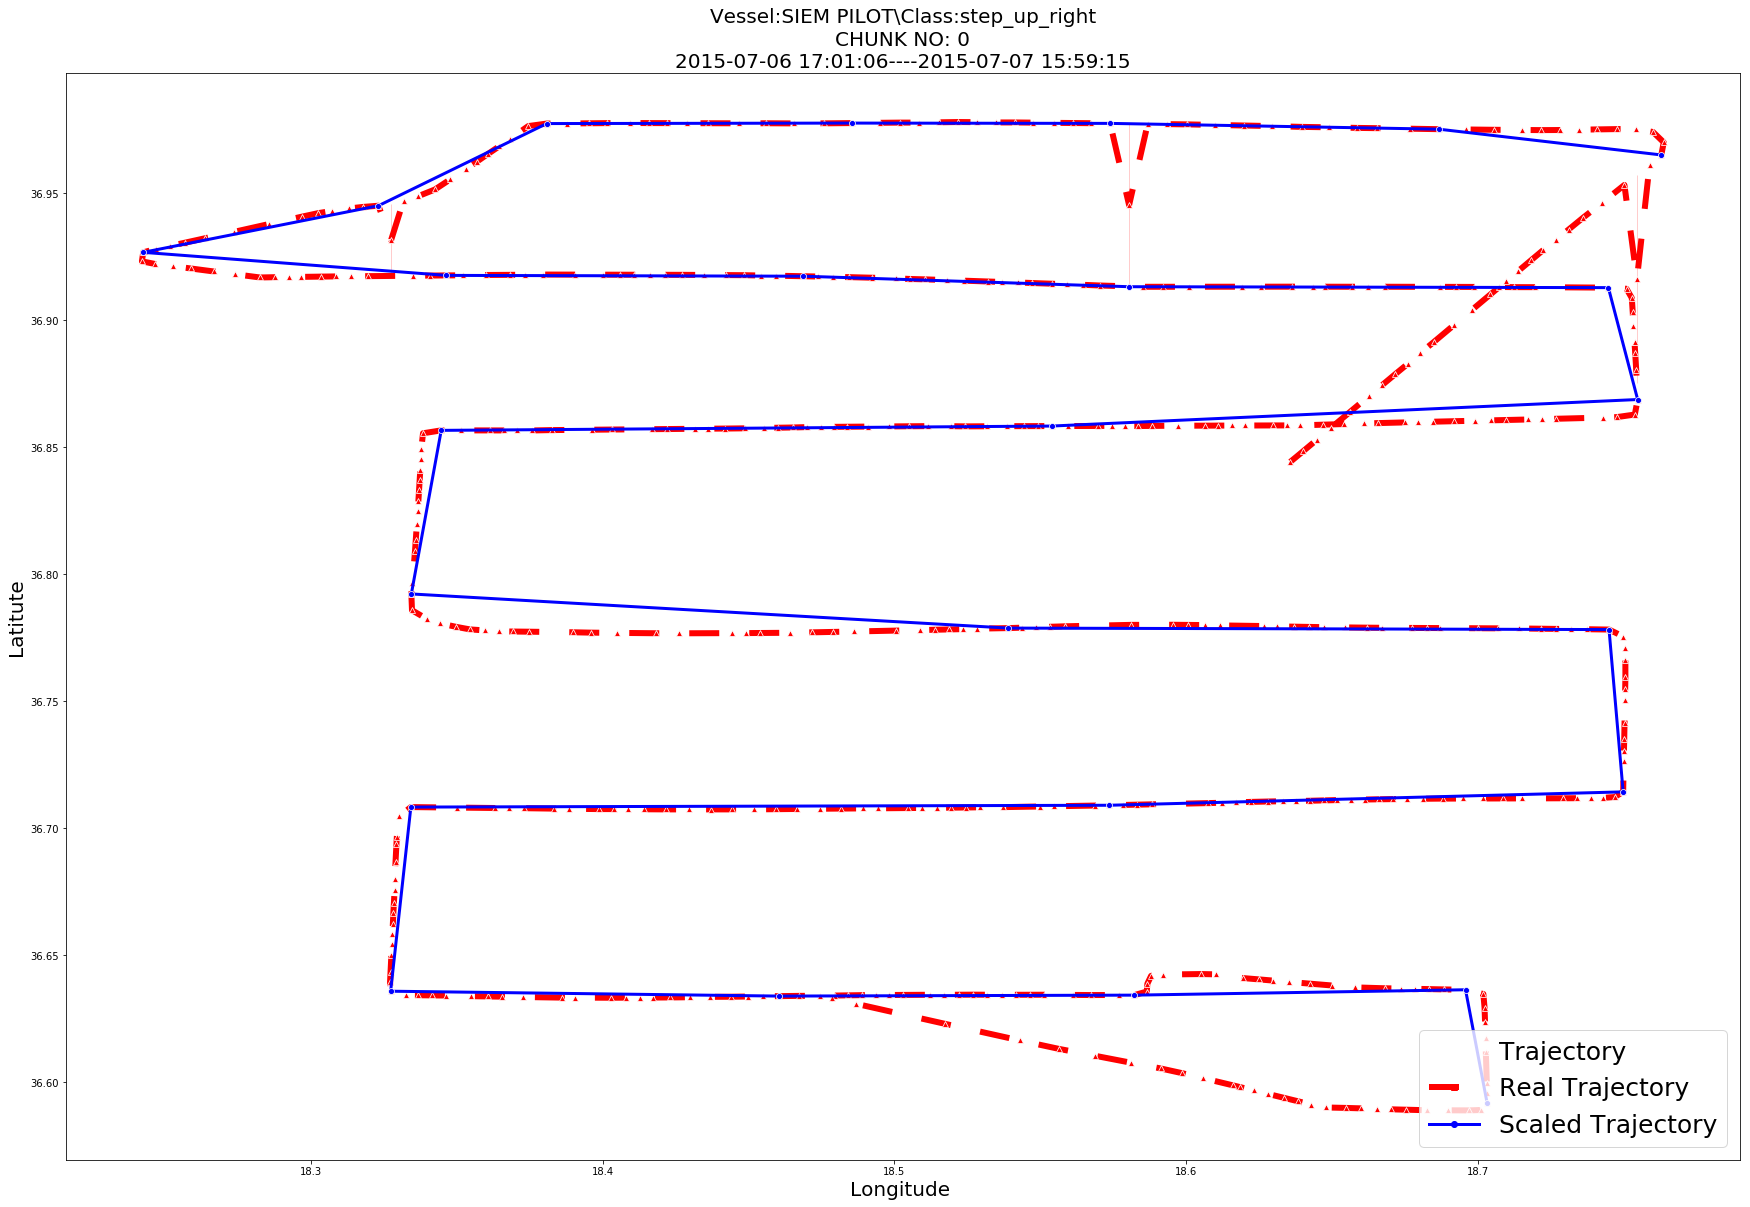

In [3]:
x = scale_down(real_data,train_test_options["split"])
x = np.array([x["HEADING"].values.astype(int)])
ship = {"shipname":"SIEM PILOT","data":x,"ship_dfs":[real_data]}
predictions,proba = experiments(ship,movement_list)
print_results(movement_list,predictions,proba)
proba_info,pattern_indexes = results(movement_list,proba,predictions)
best_patterns = find_best_patterns(proba_info)
plots(movement_list=movement_list,
      pattern_indexes=pattern_indexes,
      best_patterns=best_patterns,
      ship_name=ship["shipname"],
      ship_dfs=ship["ship_dfs"])

<b>Second case :</b> check for a known case of pattern (creeping_line_left for SIEM PILOT ship) if the result of classification is right with the use of rdp algorithm before the scale_down section

for chunk 0 and pattern step_up_right a prediction is made with probability 0.6233603699417859
0 times of pattern detection: step_up_left  at indexes  []
1 times of pattern detection: step_up_right  at indexes  [0]
0 times of pattern detection: spiral_movement_left  at indexes  []
0 times of pattern detection: spiral_movement_right  at indexes  []
0 times of pattern detection: expanding_square_left  at indexes  []
0 times of pattern detection: expanding_square_right  at indexes  []
0 times of pattern detection: creeping_line_left  at indexes  []
0 times of pattern detection: creeping_line_right  at indexes  []
0 times of pattern detection: sector_pattern_left  at indexes  []
0 times of pattern detection: sector_pattern_right  at indexes  []


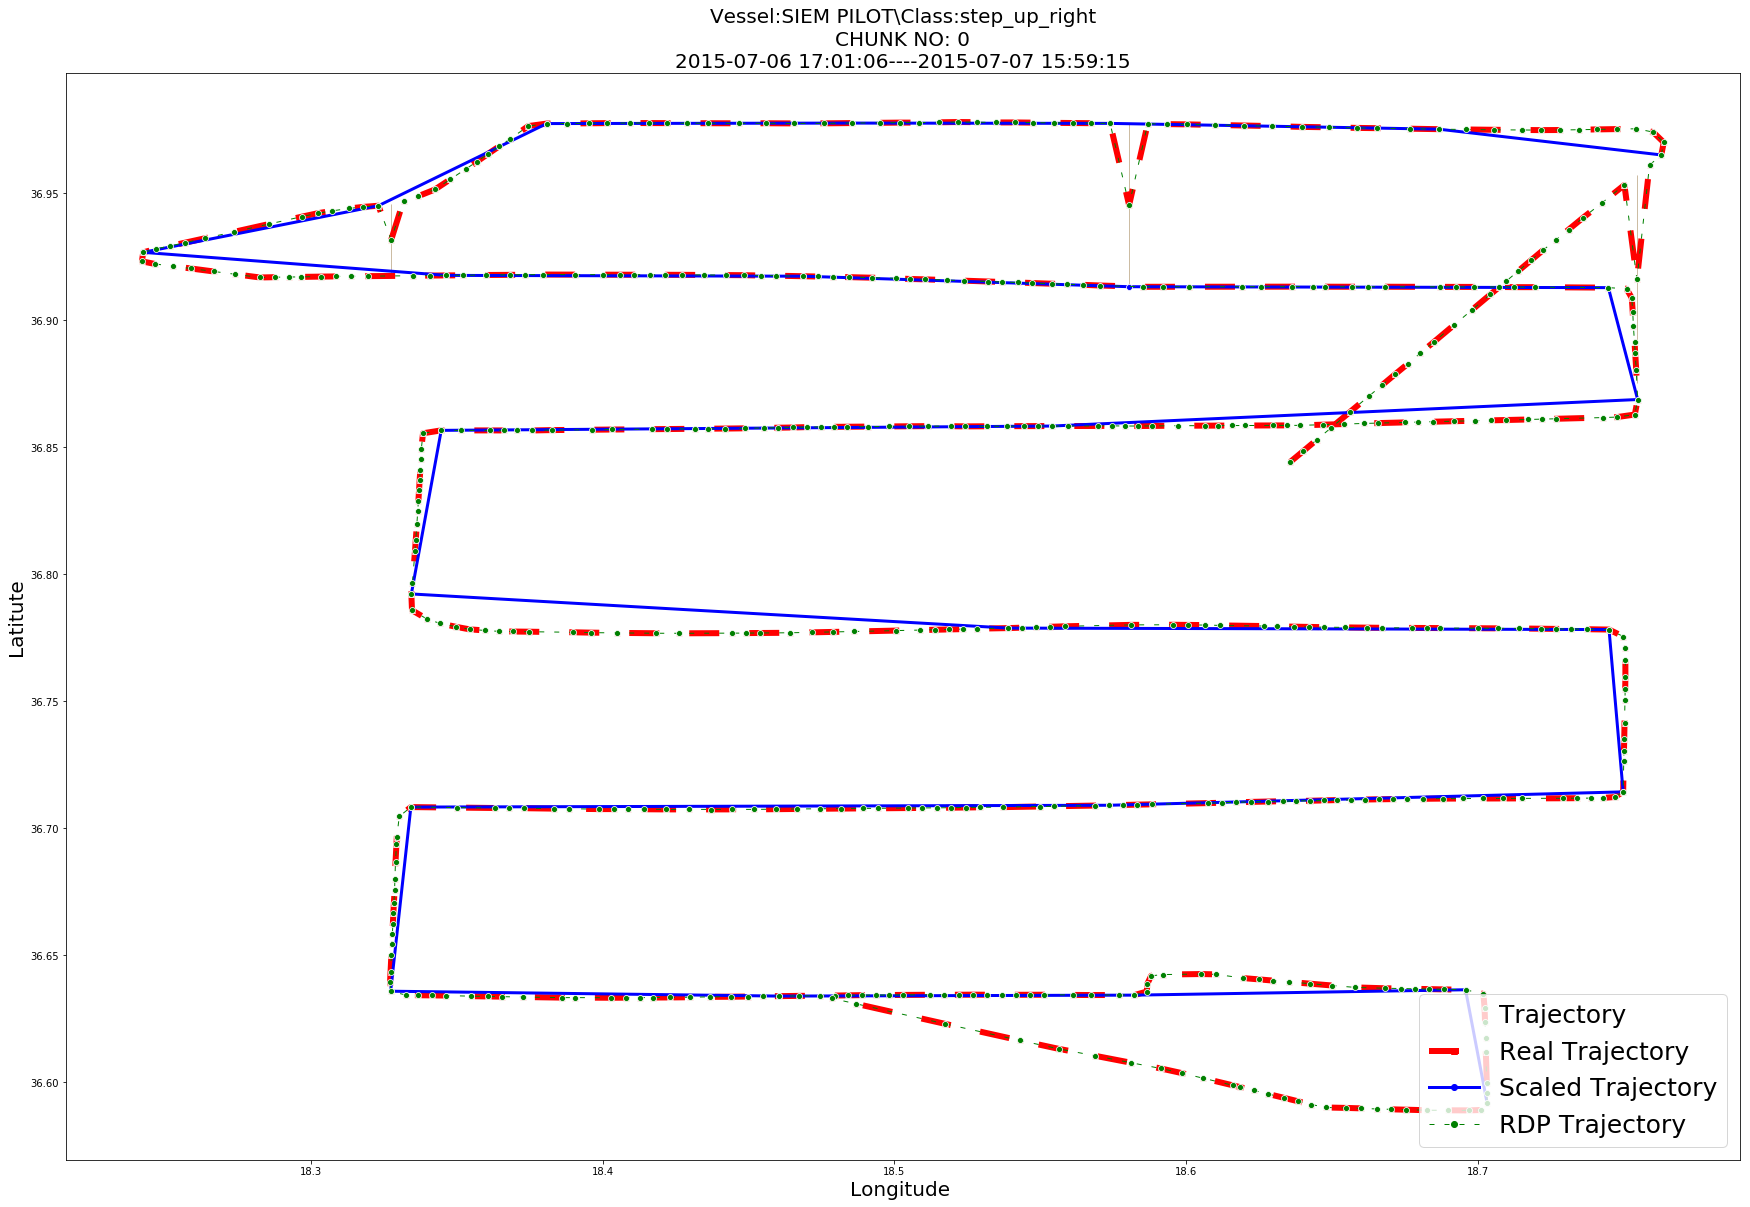

In [4]:
lat = np.array(real_data["LAT"])
lon = np.array(real_data["LON"])
np_real_data = [np.array([x,lon[idx]]) for idx,x in enumerate(lat)]
mask = rdp(np_real_data,algo="iter", return_mask=True,epsilon=0.005)
rdp_real_data =  real_data[mask]
if len(rdp_real_data) == train_test_options["split"]:
    rdp_x = scale_down(rdp_real_data,train_test_options["split"])
    rdp_x = np.array([rdp_x["HEADING"].values.astype(int)])
    rdp_ship = {"shipname":"SIEM PILOT","data":rdp_x,"ship_dfs":[rdp_real_data]}
    rdp_predictions,rdp_proba = experiments(rdp_ship,movement_list)
    print_results(movement_list,rdp_predictions,rdp_proba)
    rdp_proba_info,rdp_pattern_indexes = results(movement_list,rdp_proba,rdp_predictions)
    rdp_best_patterns = find_best_patterns(rdp_proba_info)
    plots(movement_list=movement_list,
          pattern_indexes=rdp_pattern_indexes,
          best_patterns=rdp_best_patterns,
          ship_name=rdp_ship["shipname"],
          ship_dfs=[real_data],
          scaled_down=True,
          rdp_data=rdp_real_data)

<b>Third case :</b> check for a known case of pattern (creeping_line_left for SIEM PILOT ship) if the result of classification is right with chunks with size 180-sample(50-sample size are too abstract to pass scale-down) (from a trajectory with size 500-sample) using scale-down (found only 3 suitable chunk after scale down )

for chunk 1 and pattern sector_pattern_left a prediction is made with probability 0.5728565881452466
for chunk 0 and pattern sector_pattern_right a prediction is made with probability 0.9395549701008108
for chunk 2 and pattern sector_pattern_right a prediction is made with probability 0.8466949295498852
0 times of pattern detection: step_up_left  at indexes  []
0 times of pattern detection: step_up_right  at indexes  []
0 times of pattern detection: spiral_movement_left  at indexes  []
0 times of pattern detection: spiral_movement_right  at indexes  []
0 times of pattern detection: expanding_square_left  at indexes  []
0 times of pattern detection: expanding_square_right  at indexes  []
0 times of pattern detection: creeping_line_left  at indexes  []
0 times of pattern detection: creeping_line_right  at indexes  []
1 times of pattern detection: sector_pattern_left  at indexes  [1]
2 times of pattern detection: sector_pattern_right  at indexes  [0, 2]


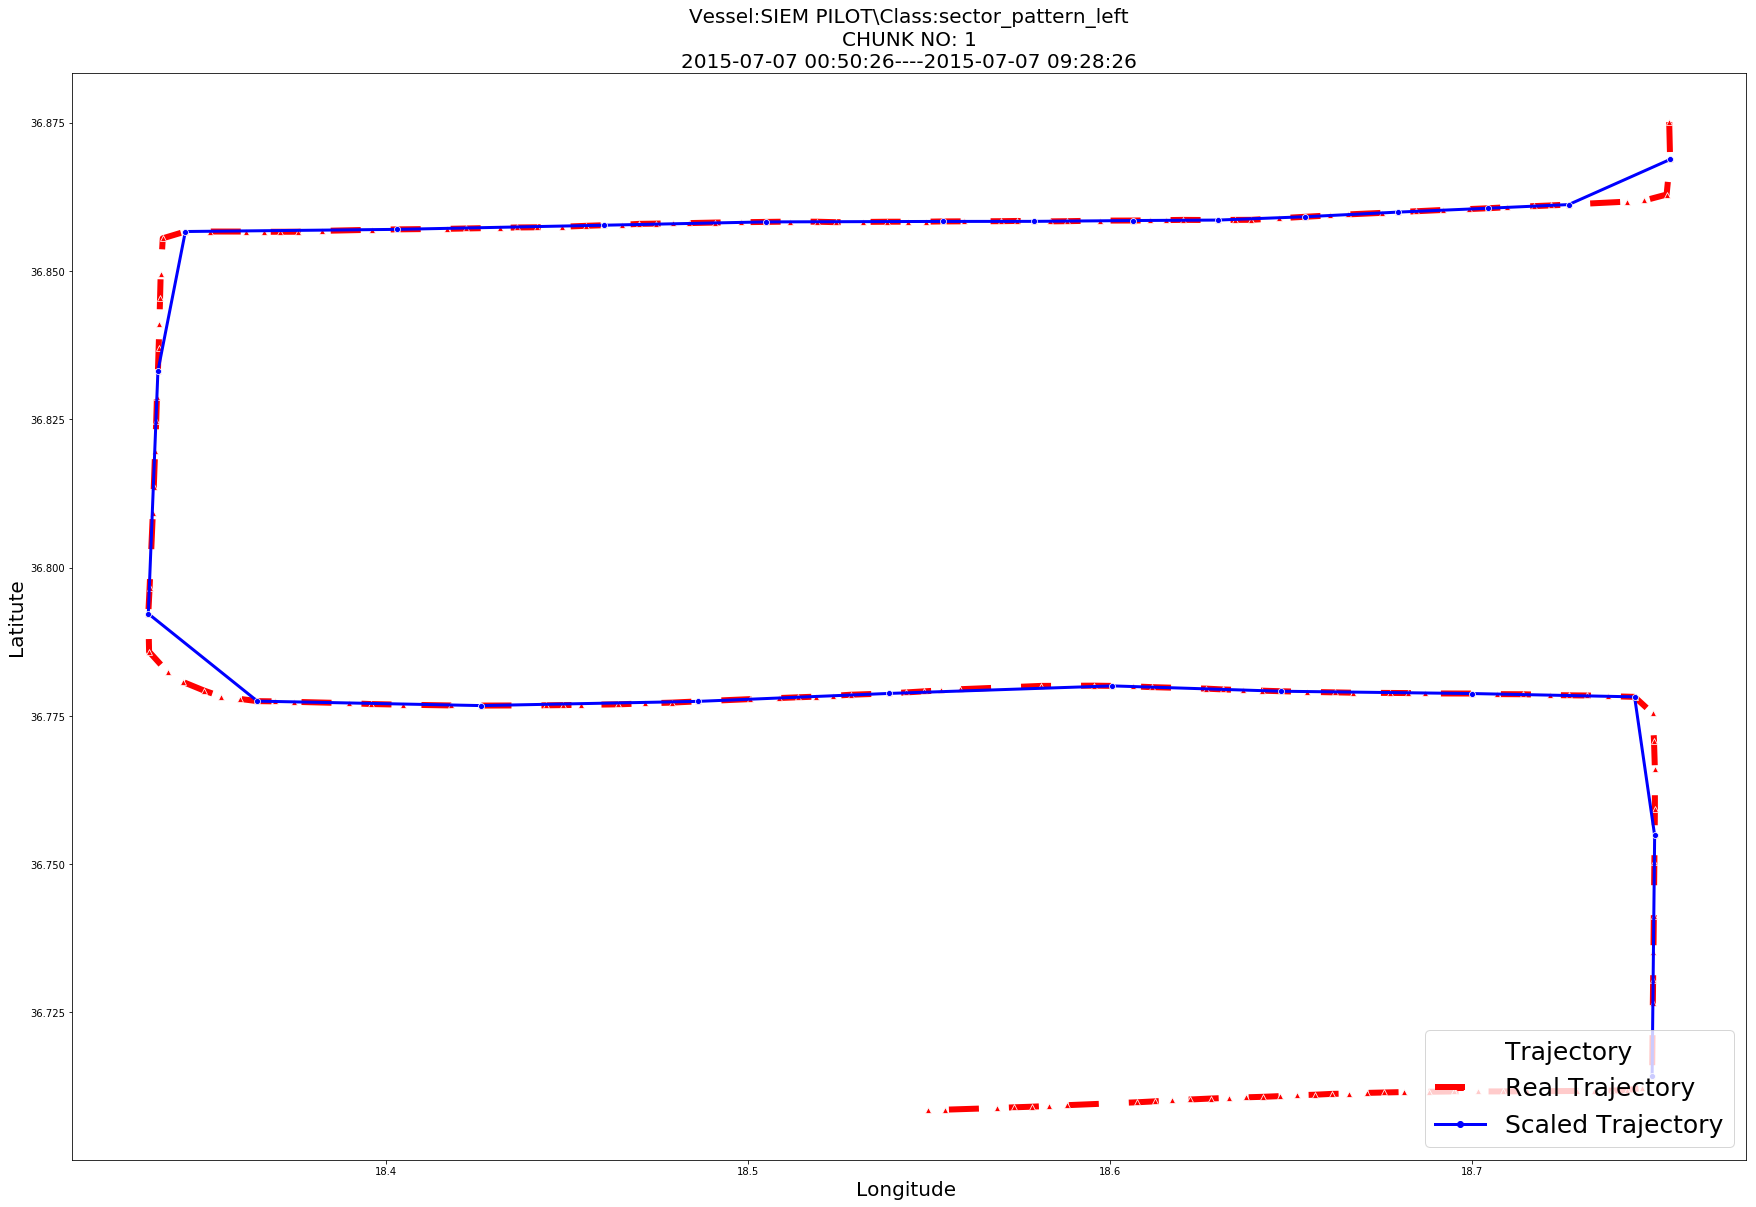

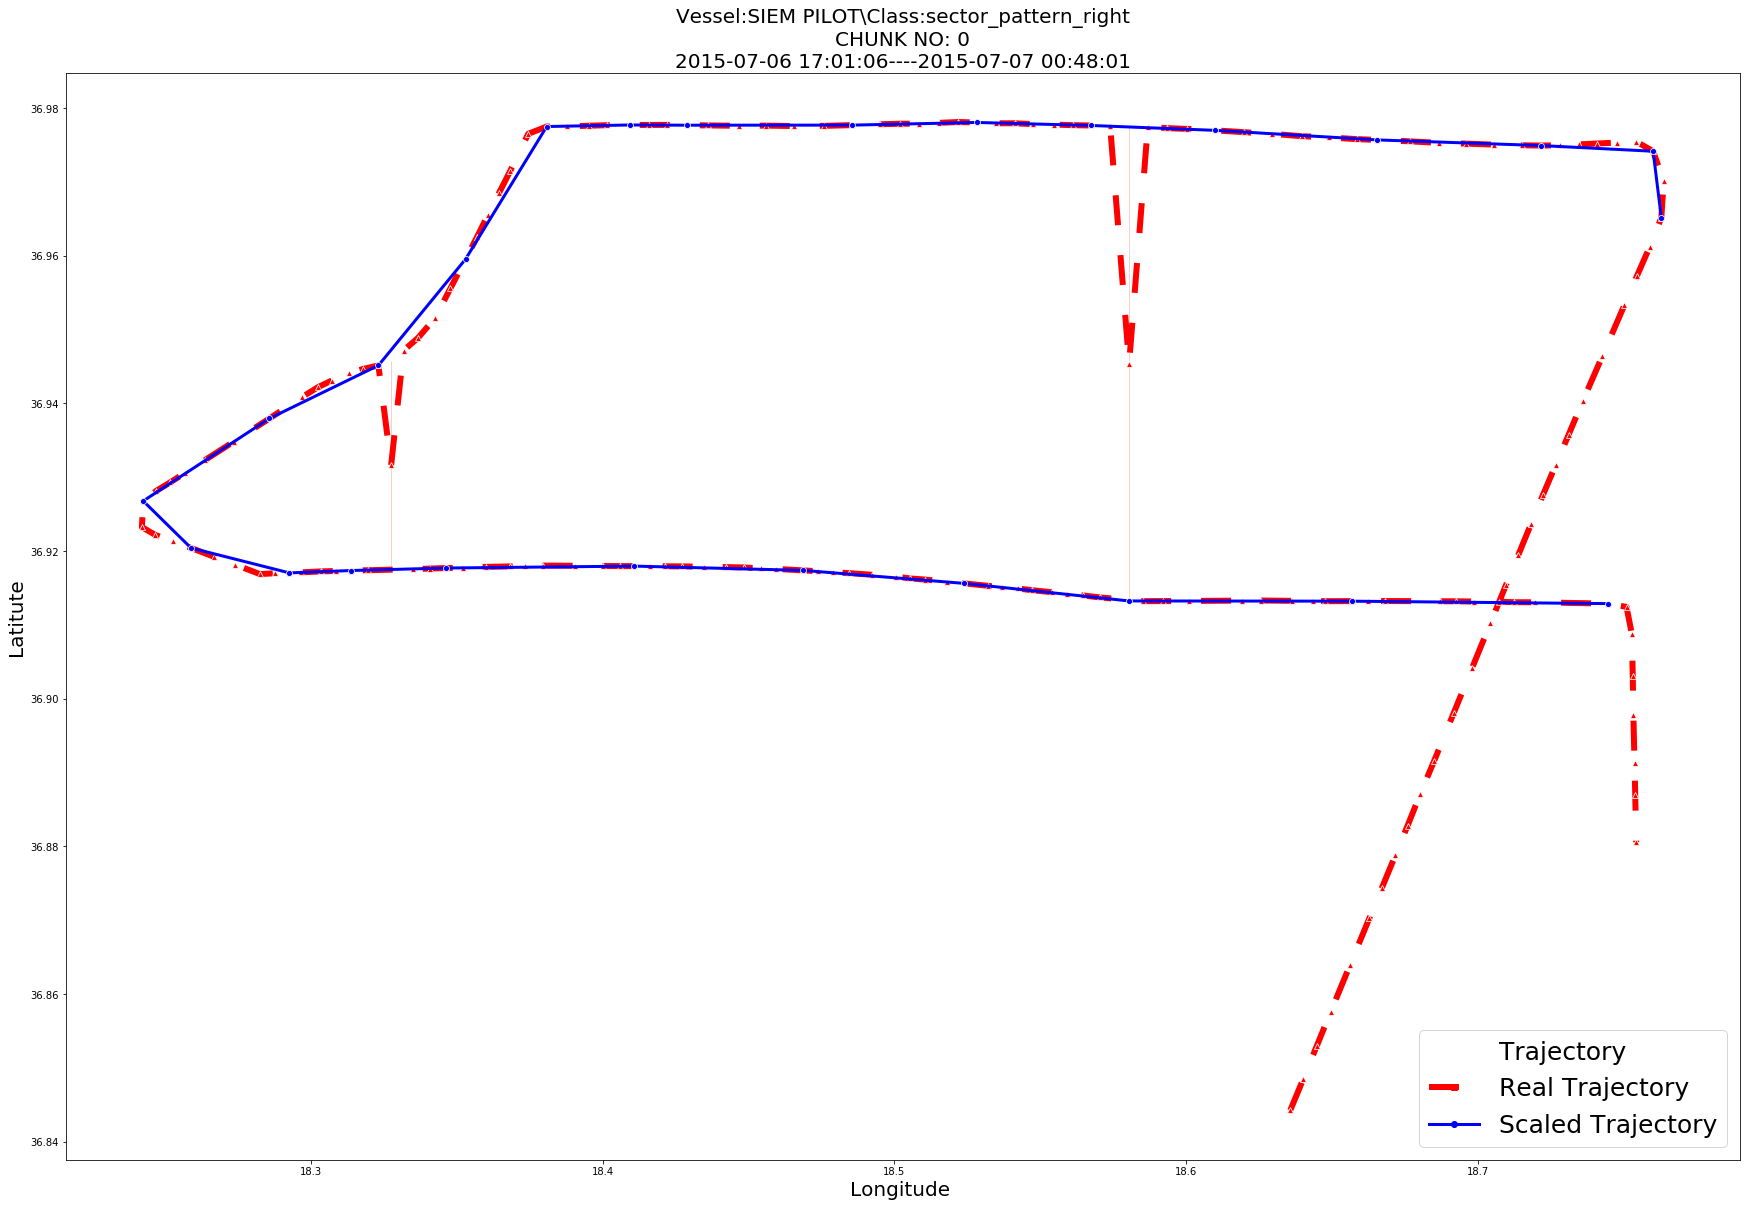

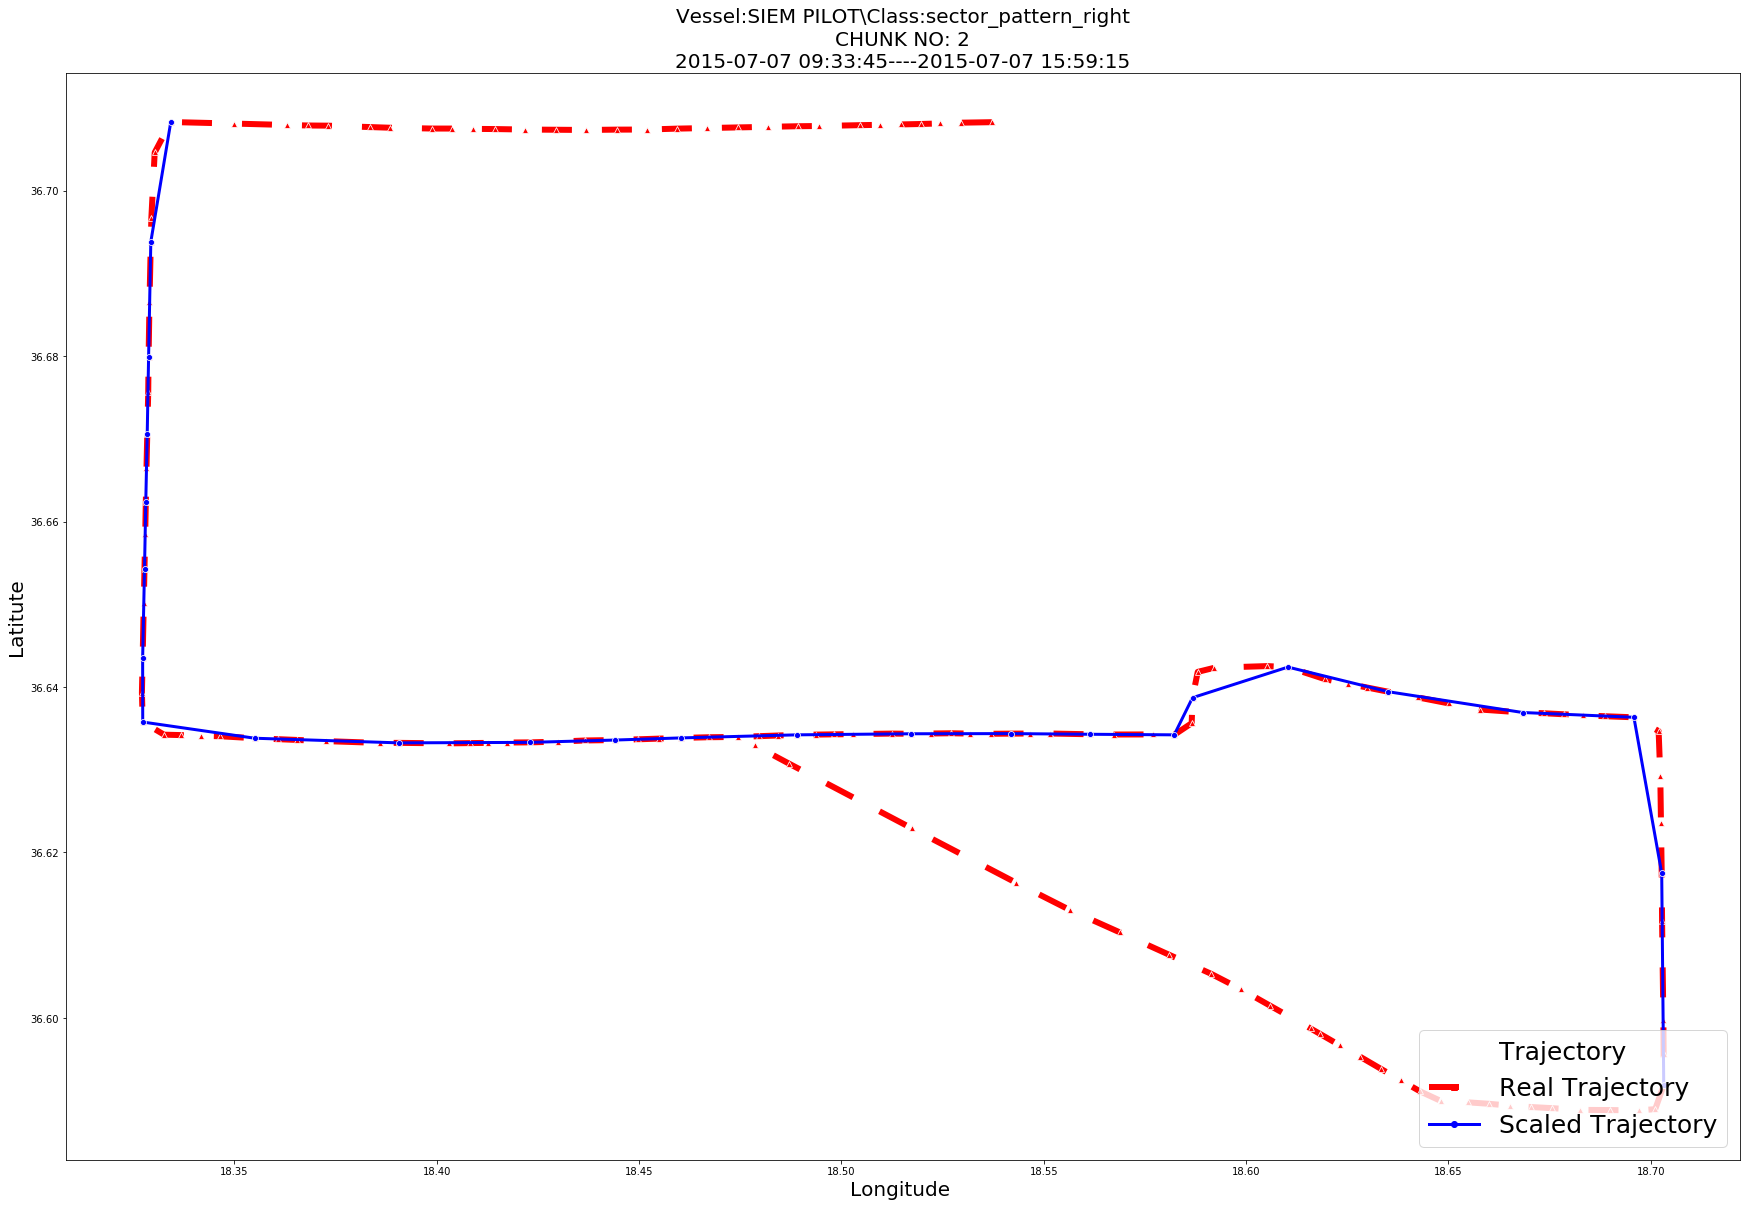

In [5]:
n = 180  #chunk row size
small_ship_dfs = [real_data[i:i+n] for i in range(0,real_data.shape[0],n)]
small_ship_data_chunked,small_ship_dfs = get_scaled_down_dfs(small_ship_dfs)
small_ship ={"shipname":"SIEM PILOT","data":small_ship_data_chunked,"ship_dfs":small_ship_dfs}
print("ERROR DIFFERENT SIZE OF DATA") if len(small_ship_dfs)!=small_ship["data"].shape[0] else None

small_predictions,small_proba = experiments(small_ship,movement_list)
print_results(movement_list,small_predictions,small_proba)
small_proba_info,small_pattern_indexes = results(movement_list,small_proba,small_predictions)
small_best_patterns = find_best_patterns(small_proba_info)
plots(movement_list=movement_list,
      pattern_indexes=small_pattern_indexes,
      best_patterns=small_best_patterns,
      ship_name=small_ship["shipname"],
      ship_dfs=small_ship["ship_dfs"])


50-sample sized chunk plots of the  of the know SIEM PILOT's trajectory

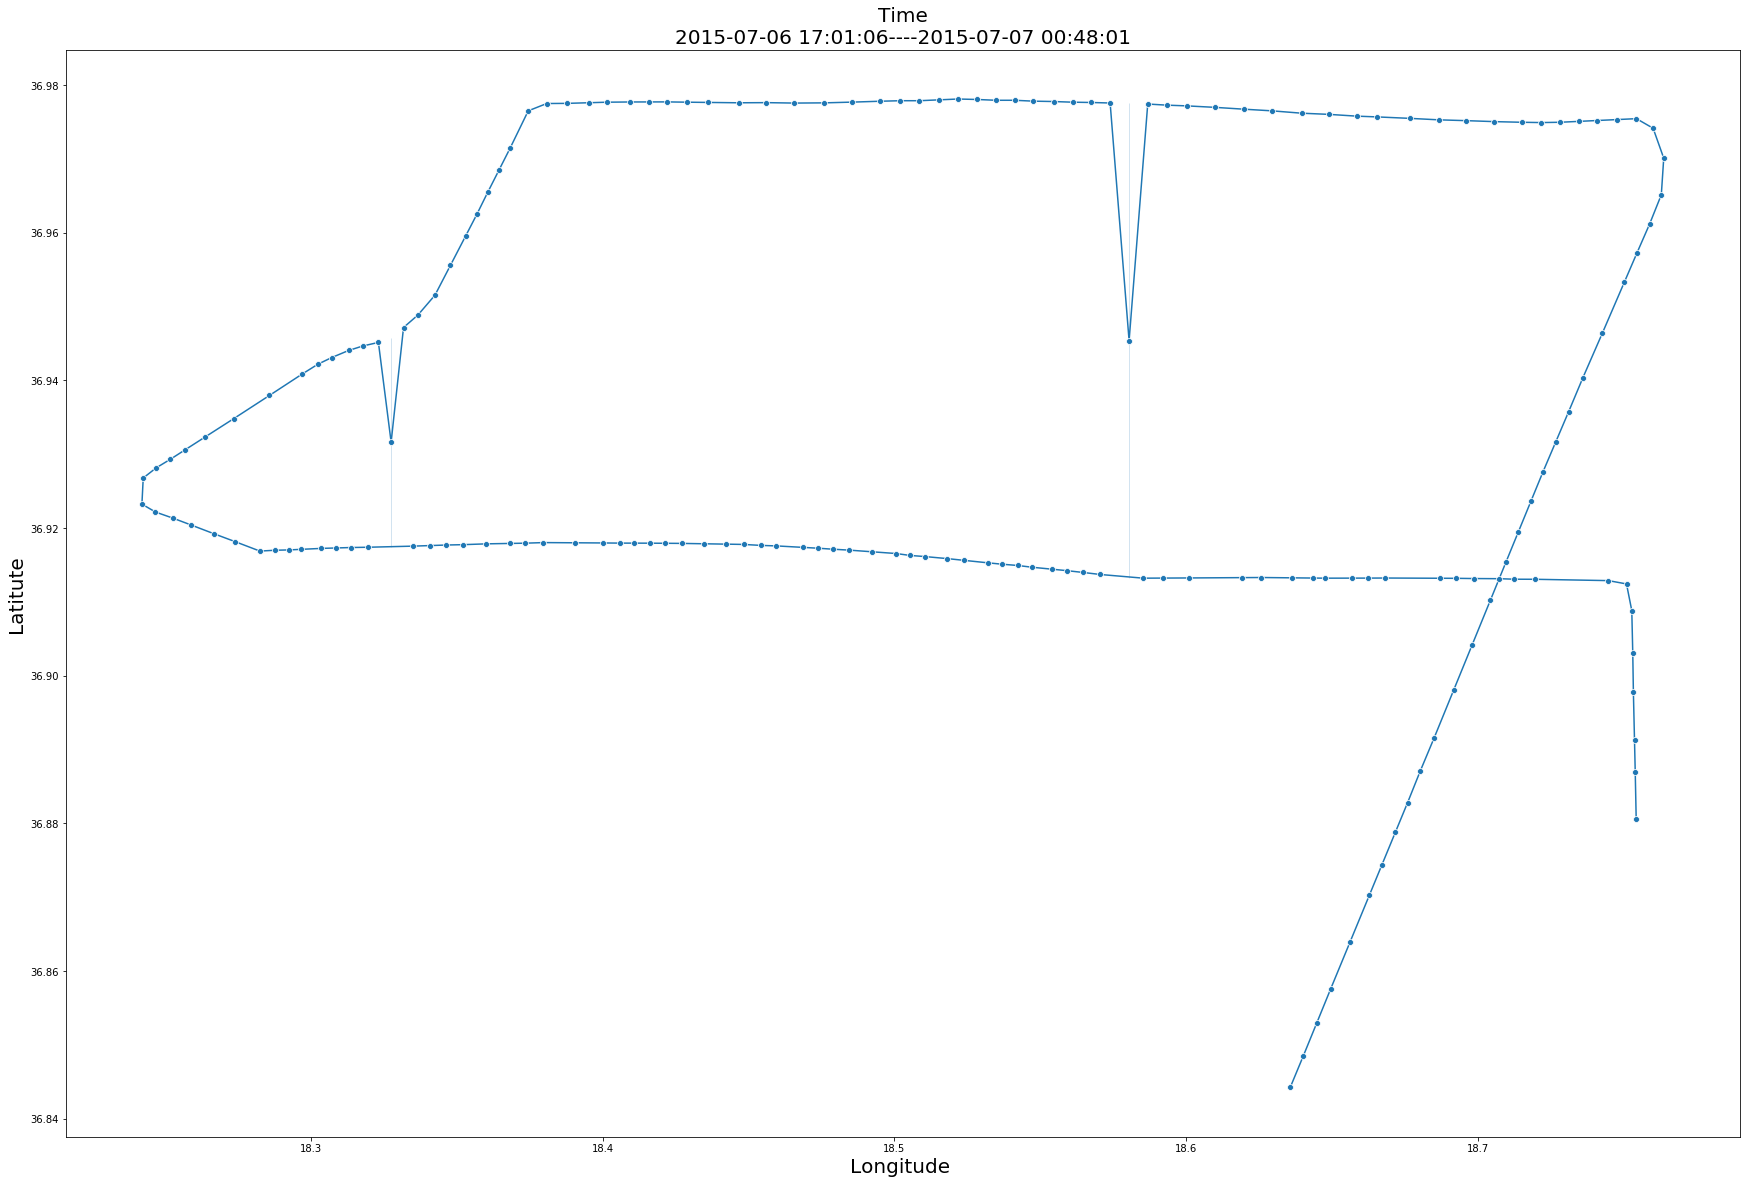

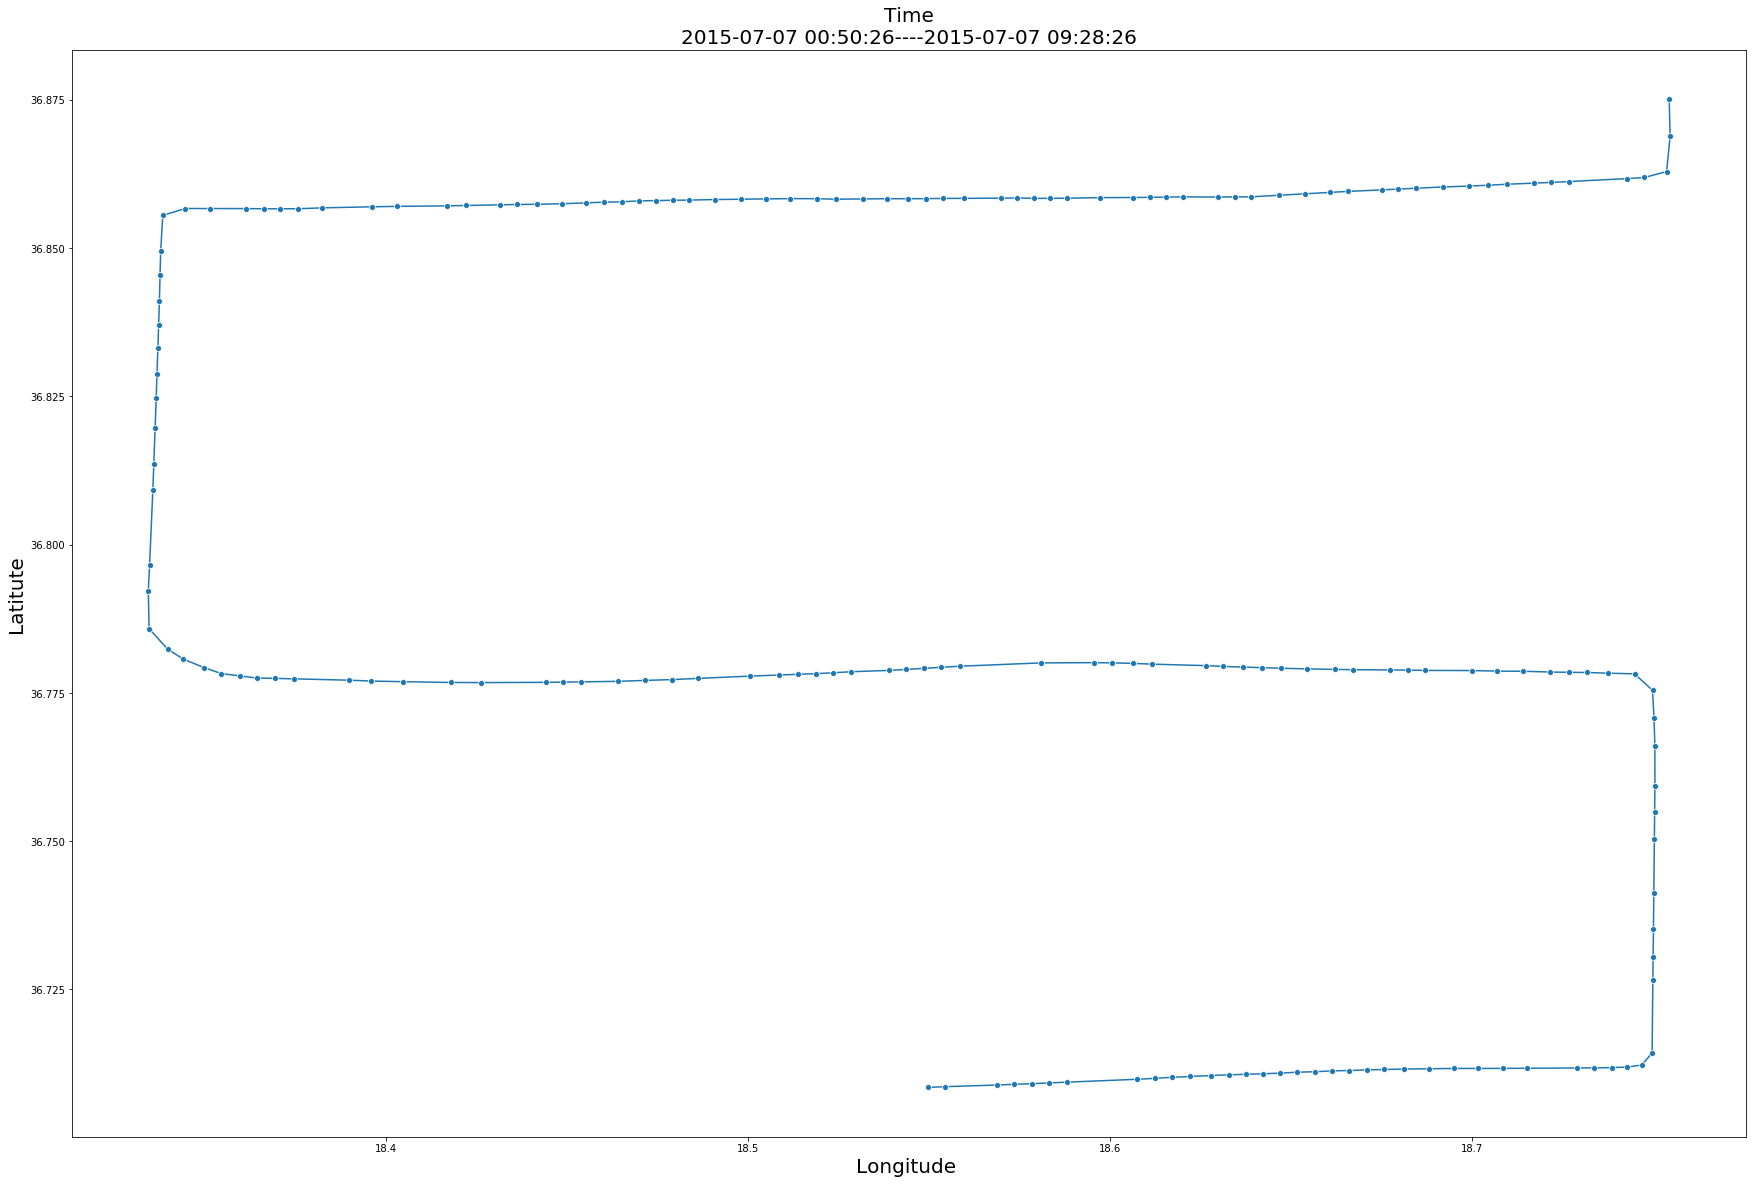

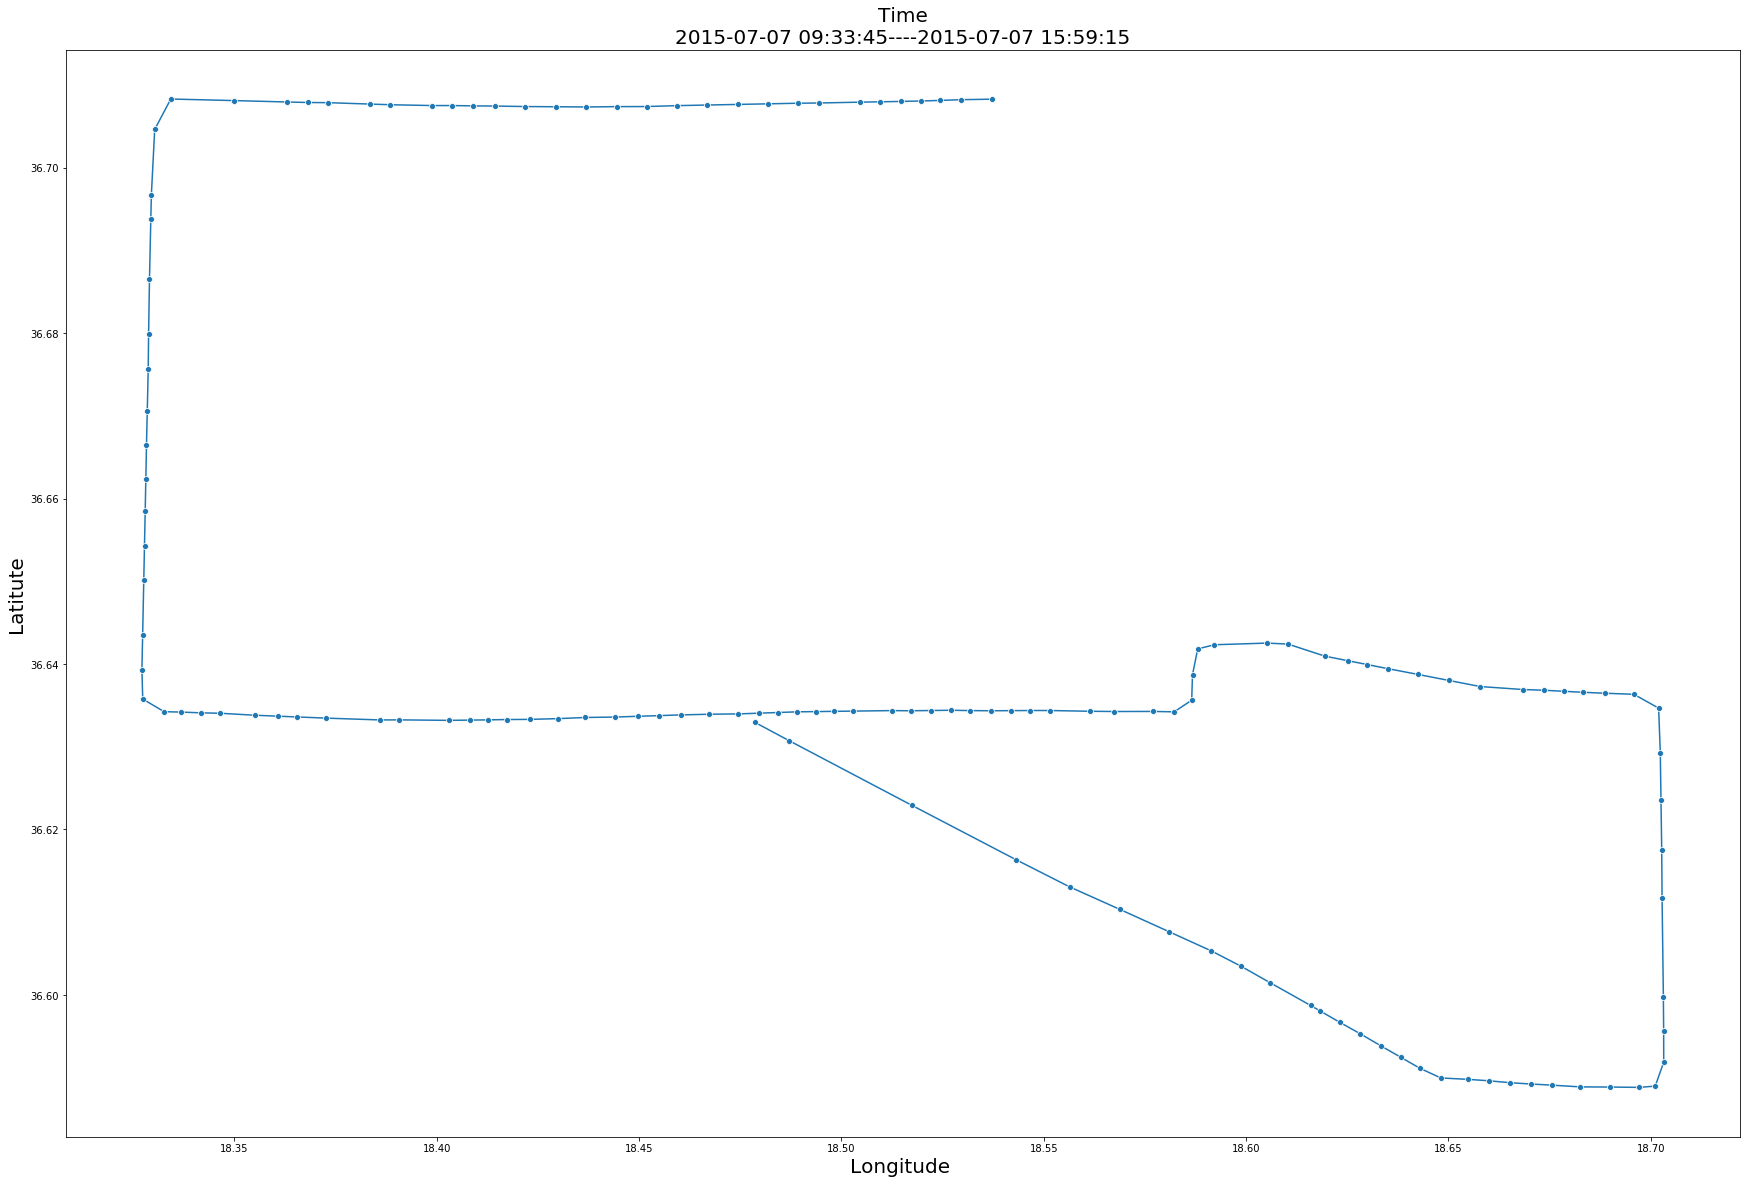

In [6]:
small_ship_dfs_chunk = [real_data[i:i+n] for i in range(0,real_data.shape[0],n)]
for p_ship in small_ship_dfs_chunk:
    fig, ax = plt.subplots()
    sns.lineplot(x='LON', y='LAT', data=p_ship, ax=ax,sort=False,marker="o")
    fig.set_size_inches(30, 20)
    ax.set_ylabel('Latitute', fontsize = 20.0) # Y label
    ax.set_xlabel('Longitude ', fontsize = 20.0) # X label
    start = datetime.strftime(p_ship["TIMESTAMP"].head(1).iloc[0],'%Y-%m-%d %H:%M:%S')
    end = datetime.strftime(p_ship["TIMESTAMP"].tail(1).iloc[0],'%Y-%m-%d %H:%M:%S')
    title = "Time\n"+start+"----"+end
    ax.set_title(title,fontsize = 20.0)

<b>Fourth case:</b> rerun of third case with rdp algorithm without scale down. The epsilon parameter is selected after extensive search in order to give 25-sample size trajectories

for chunk 0 and pattern sector_pattern_left a prediction is made with probability 0.8567259153806678
0 times of pattern detection: step_up_left  at indexes  []
0 times of pattern detection: step_up_right  at indexes  []
0 times of pattern detection: spiral_movement_left  at indexes  []
0 times of pattern detection: spiral_movement_right  at indexes  []
0 times of pattern detection: expanding_square_left  at indexes  []
0 times of pattern detection: expanding_square_right  at indexes  []
0 times of pattern detection: creeping_line_left  at indexes  []
0 times of pattern detection: creeping_line_right  at indexes  []
1 times of pattern detection: sector_pattern_left  at indexes  [0]
0 times of pattern detection: sector_pattern_right  at indexes  []


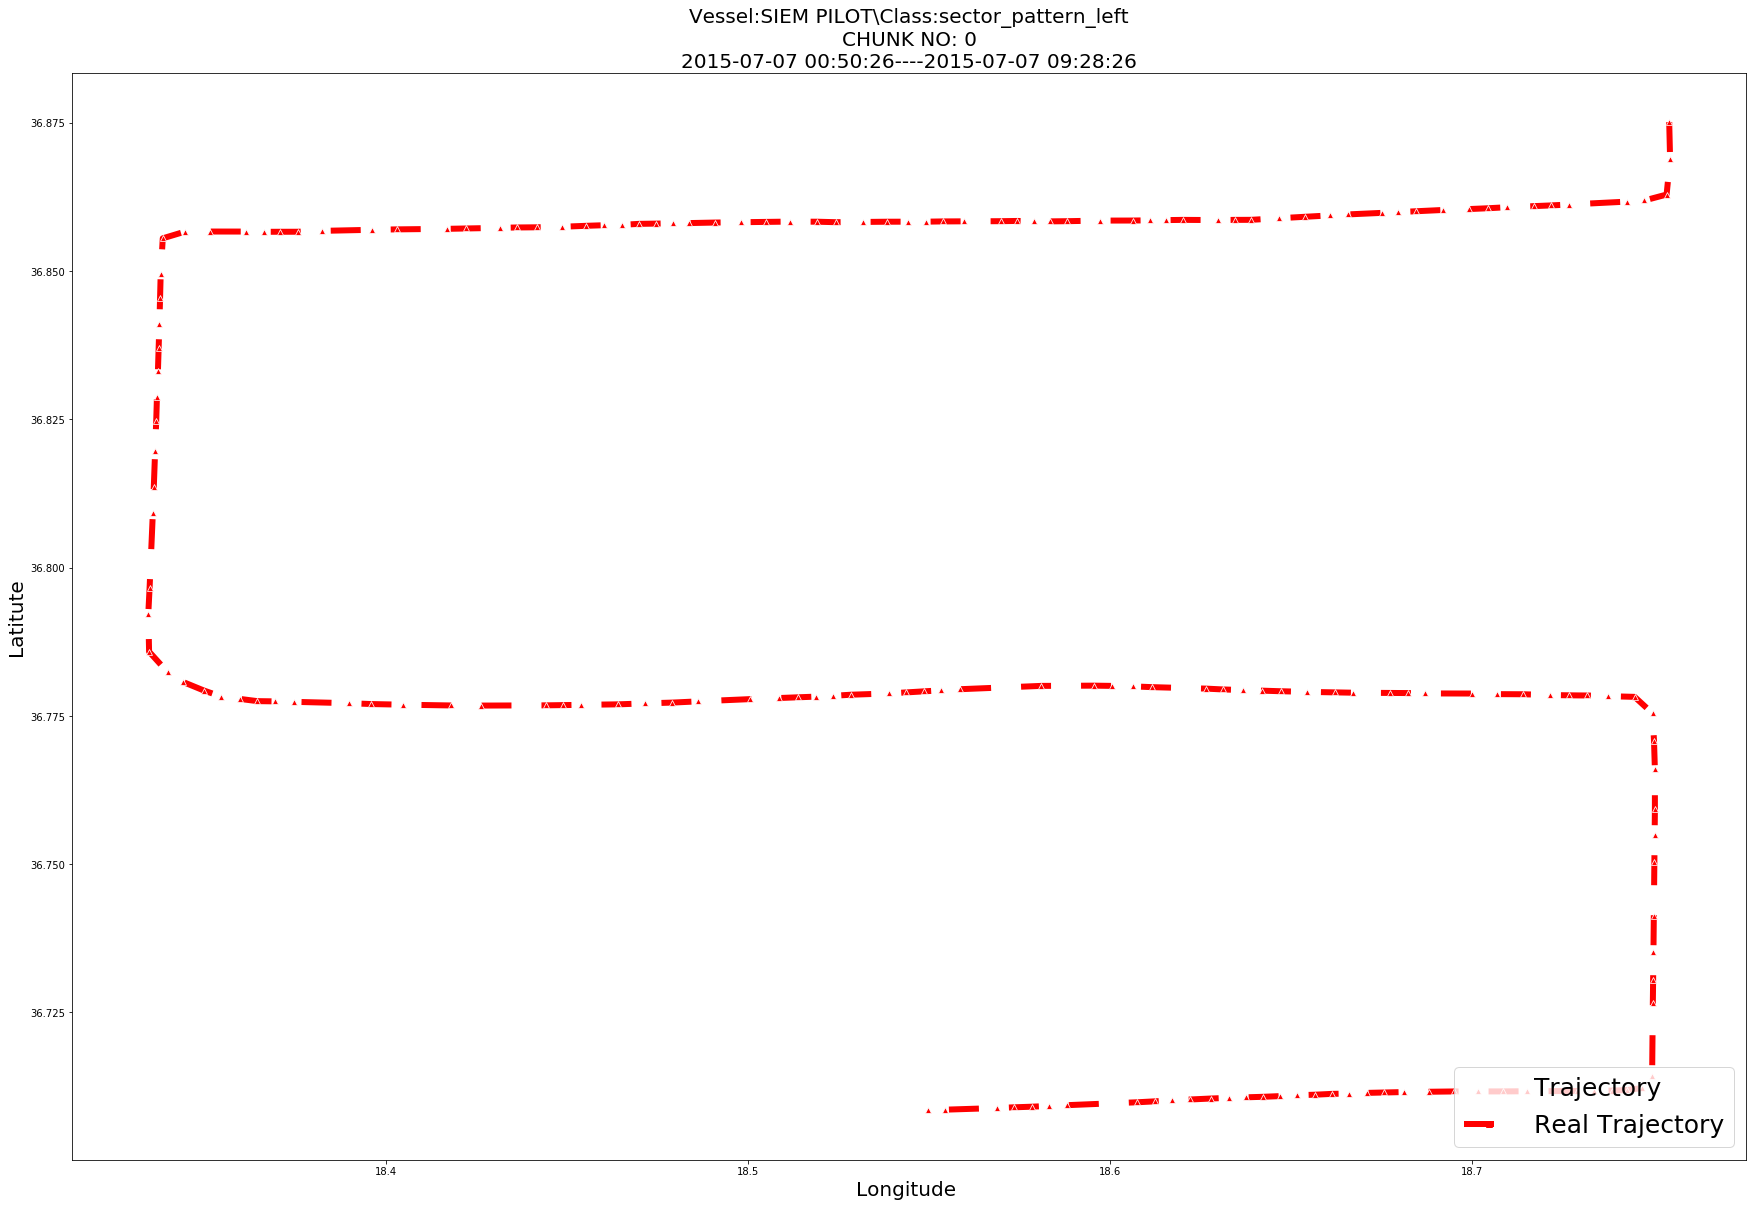

In [7]:
n = 180  #chunk row size
small_ship_dfs = [real_data[i:i+n] for i in range(0,real_data.shape[0],n)]
small_ship_data_chunked = []
small_ship_data_chunked_index = [False for i in range(0,len(small_ship_dfs))]  

for idx,small_x in enumerate(small_ship_dfs):
    small_lat = np.array(small_x["LAT"])
    small_lon = np.array(small_x["LON"])
    small_np_data= [np.array([x,small_lon[idx]]) for idx,x in enumerate(small_lat)]
    mask = epsilon_selection(len(small_x),small_np_data,train_test_options["split"])
    if mask:
        small_rdp_x =  small_x[mask]
        if len(small_rdp_x) == train_test_options["split"]:
            small_rdp_x = np.array(small_rdp_x["HEADING"].values.astype(int))
            small_ship_data_chunked_index[idx] = True
            small_ship_data_chunked.append(small_rdp_x)


small_ship_data_chunked = np.array(small_ship_data_chunked)
small_ship_dfs = [small_ship for (small_ship,index) in zip(small_ship_dfs,small_ship_data_chunked_index) if  index ]
small_rdp_ship ={"shipname":"SIEM PILOT","data":small_ship_data_chunked,"ship_dfs":small_ship_dfs}
print("ERROR DIFFERENT SIZE OF DATA") if len(small_ship_dfs)!=small_rdp_ship["data"].shape[0] else None

small_rdp_predictions,small_rdp_proba = experiments(small_rdp_ship,movement_list)
print_results(movement_list,small_rdp_predictions,small_rdp_proba)
small_rdp_proba_info,small_rdp_pattern_indexes = results(movement_list,small_rdp_proba,small_rdp_predictions)
small_rdp_best_patterns = find_best_patterns(small_rdp_proba_info)
plots(movement_list=movement_list,
      pattern_indexes=small_rdp_pattern_indexes,
      best_patterns=small_rdp_best_patterns,
      ship_name=small_rdp_ship["shipname"],
      ship_dfs=small_rdp_ship["ship_dfs"],
      scaled_down=False)

<b>Rerun</b> all above cases with the appropriate chunks that real_data_experiment marked as chunks classified to <b>a pattern and have some significance</b> (chunks with index :,1,3,5,16,23,27,33 after the scale down)

In [8]:
ship,shipname=read_ship_csv("ships/SIEM PILOT.csv")
n = 500  #chunk row size
ship_dfs = [ship[i:i+n] for i in range(0,ship.shape[0],n)]  
ship_data_chunked, ship_dfs = get_scaled_down_dfs(ship_dfs)
selected_trajectories = [False for i in range(0,len(ship_dfs))]
for j,i in enumerate(ship_dfs):
    if j in [1,4,5,9]:
        selected_trajectories[j] = True
ship_dfs = [ship for (ship,index) in zip(ship_dfs,selected_trajectories) if  index ]
ship_data_chunked = np.array([ship for (ship,index) in zip(ship_data_chunked,selected_trajectories) if  index ])
ship ={"shipname":shipname,"data":ship_data_chunked,"ship_dfs":ship_dfs}


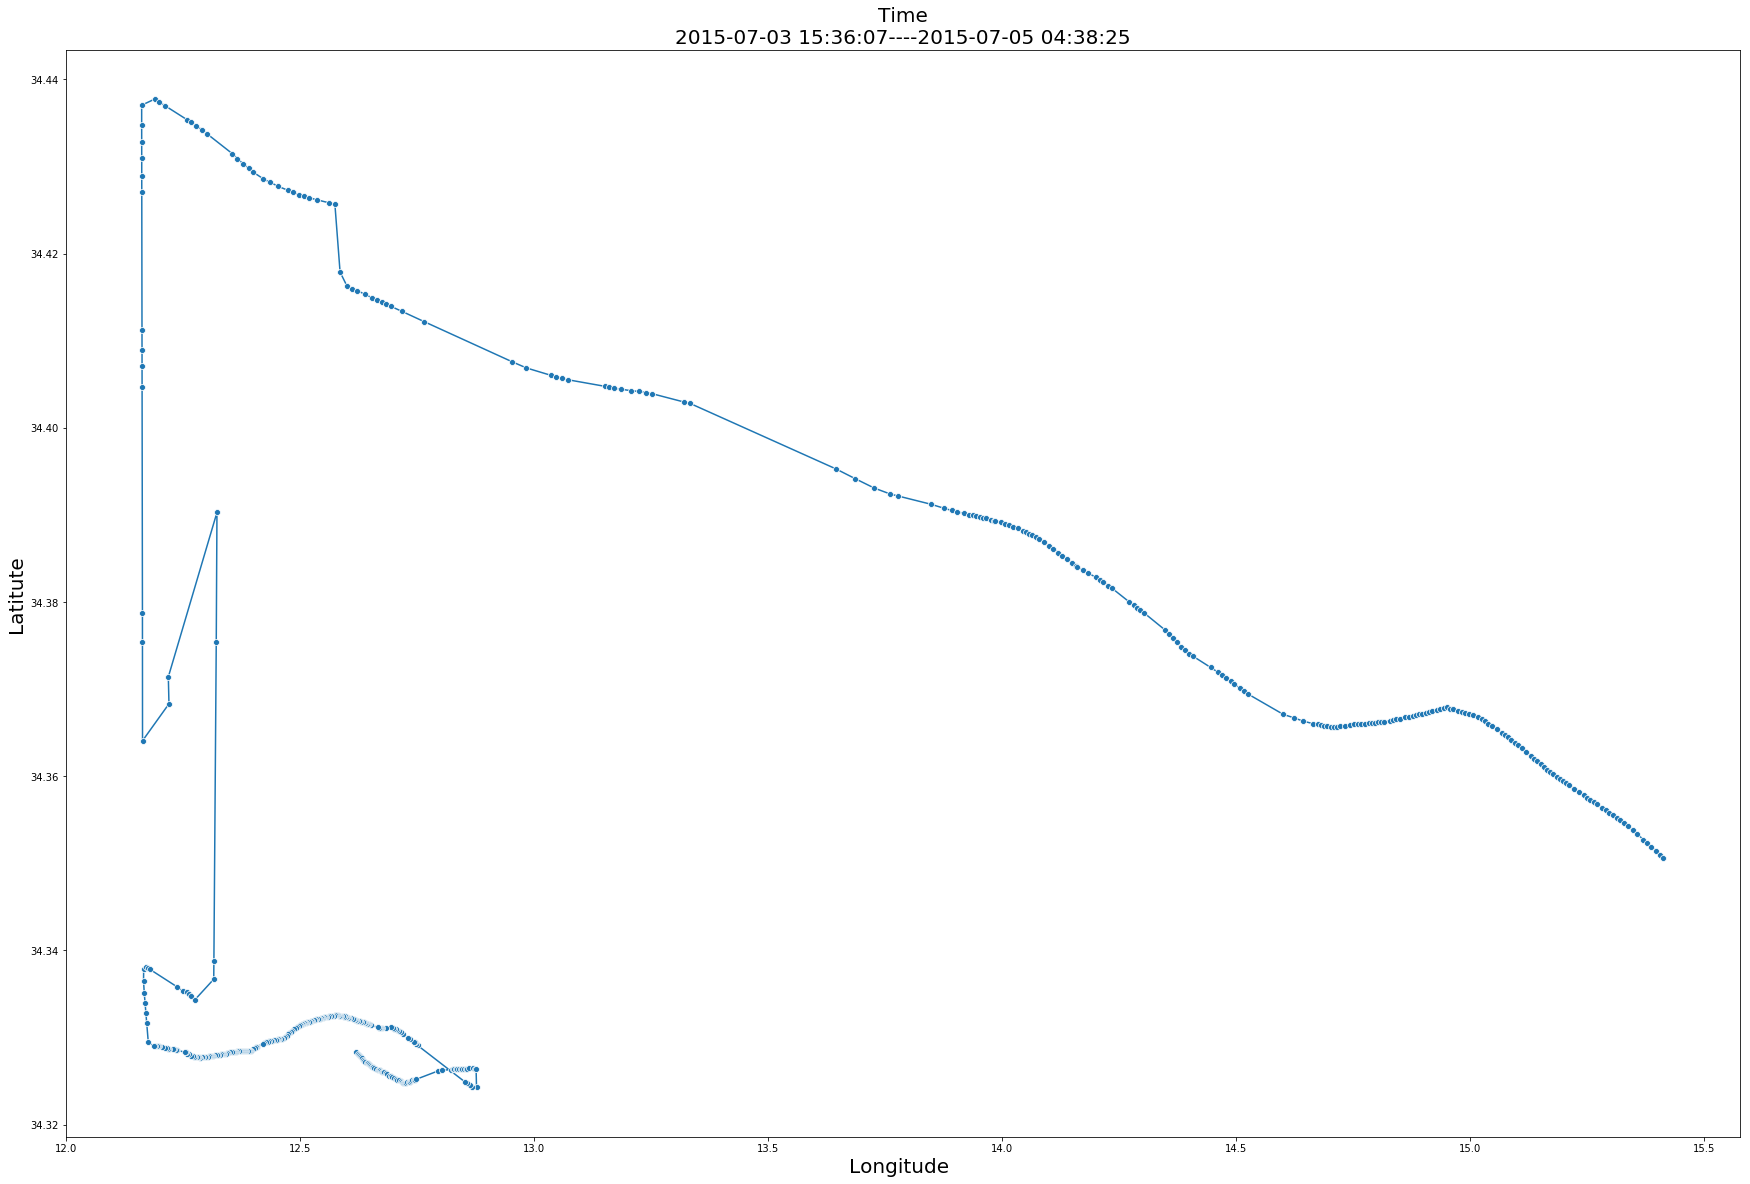

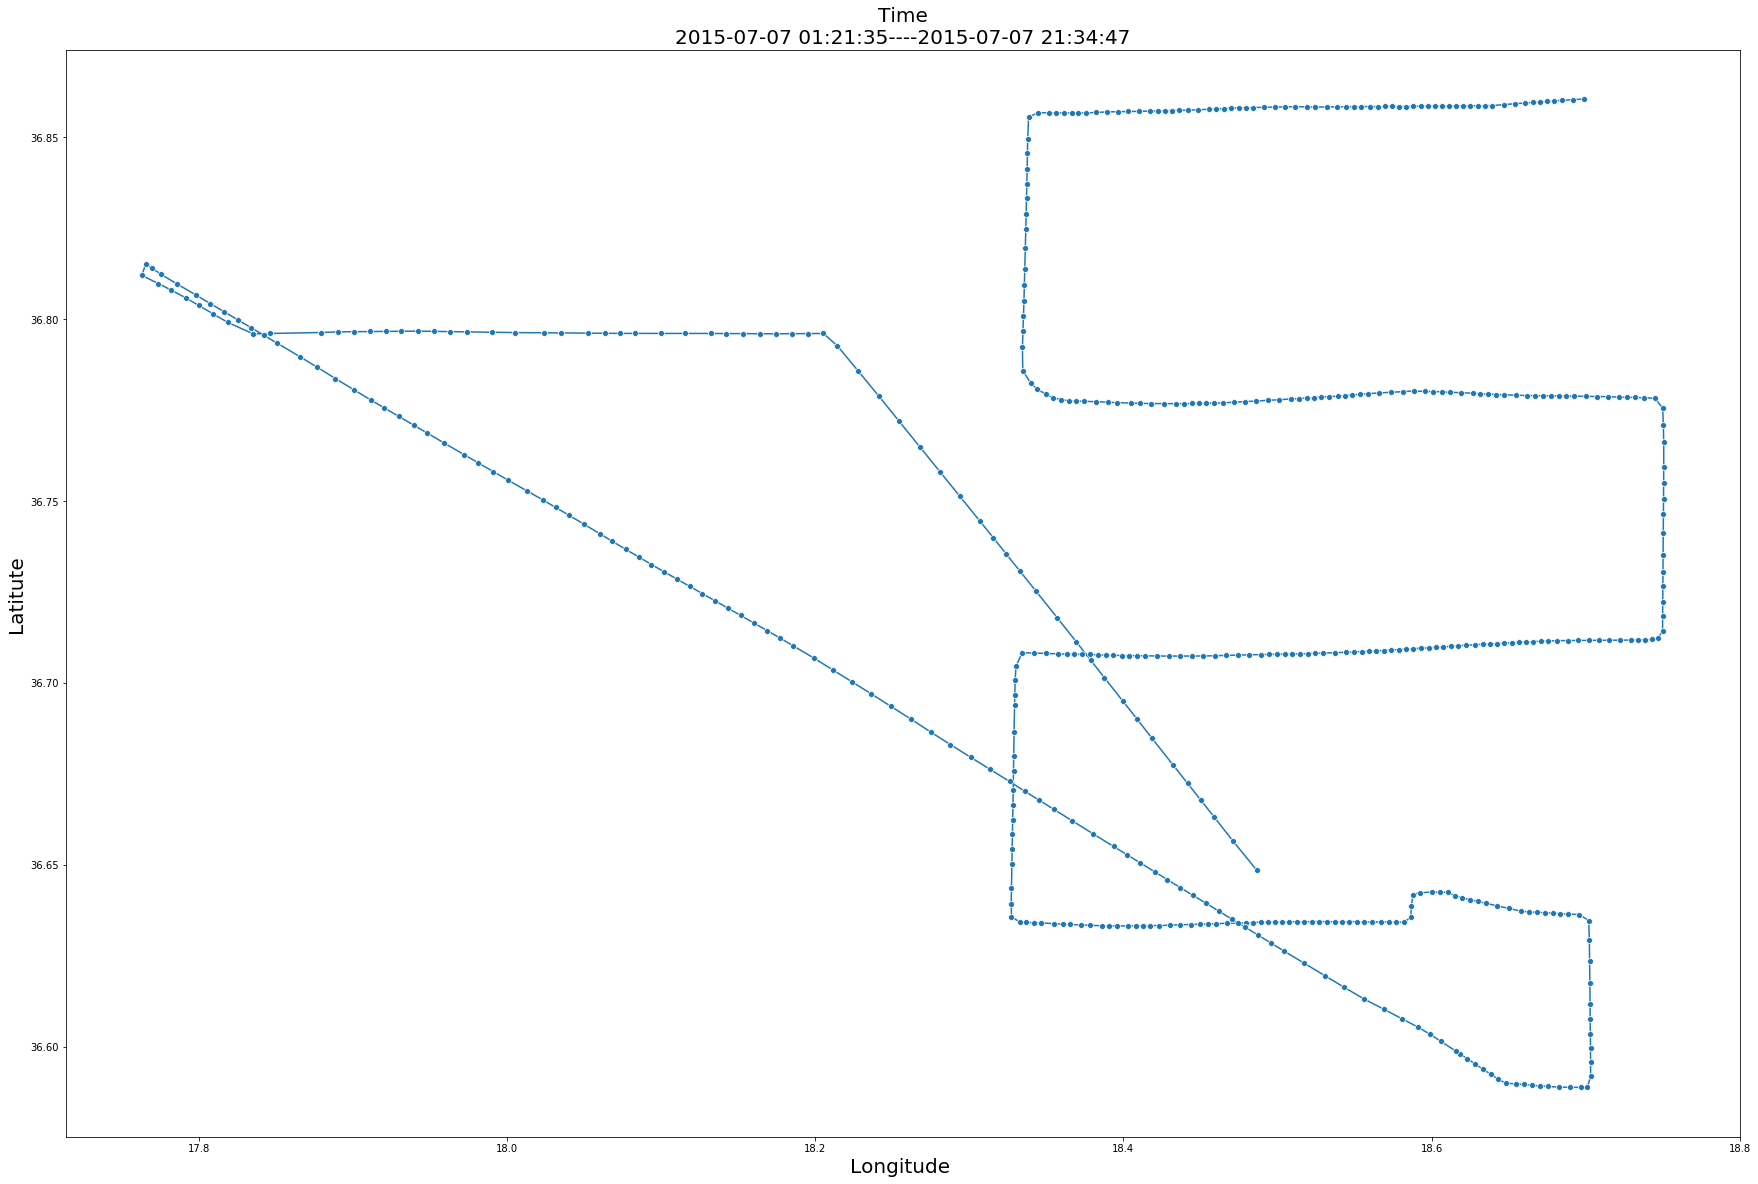

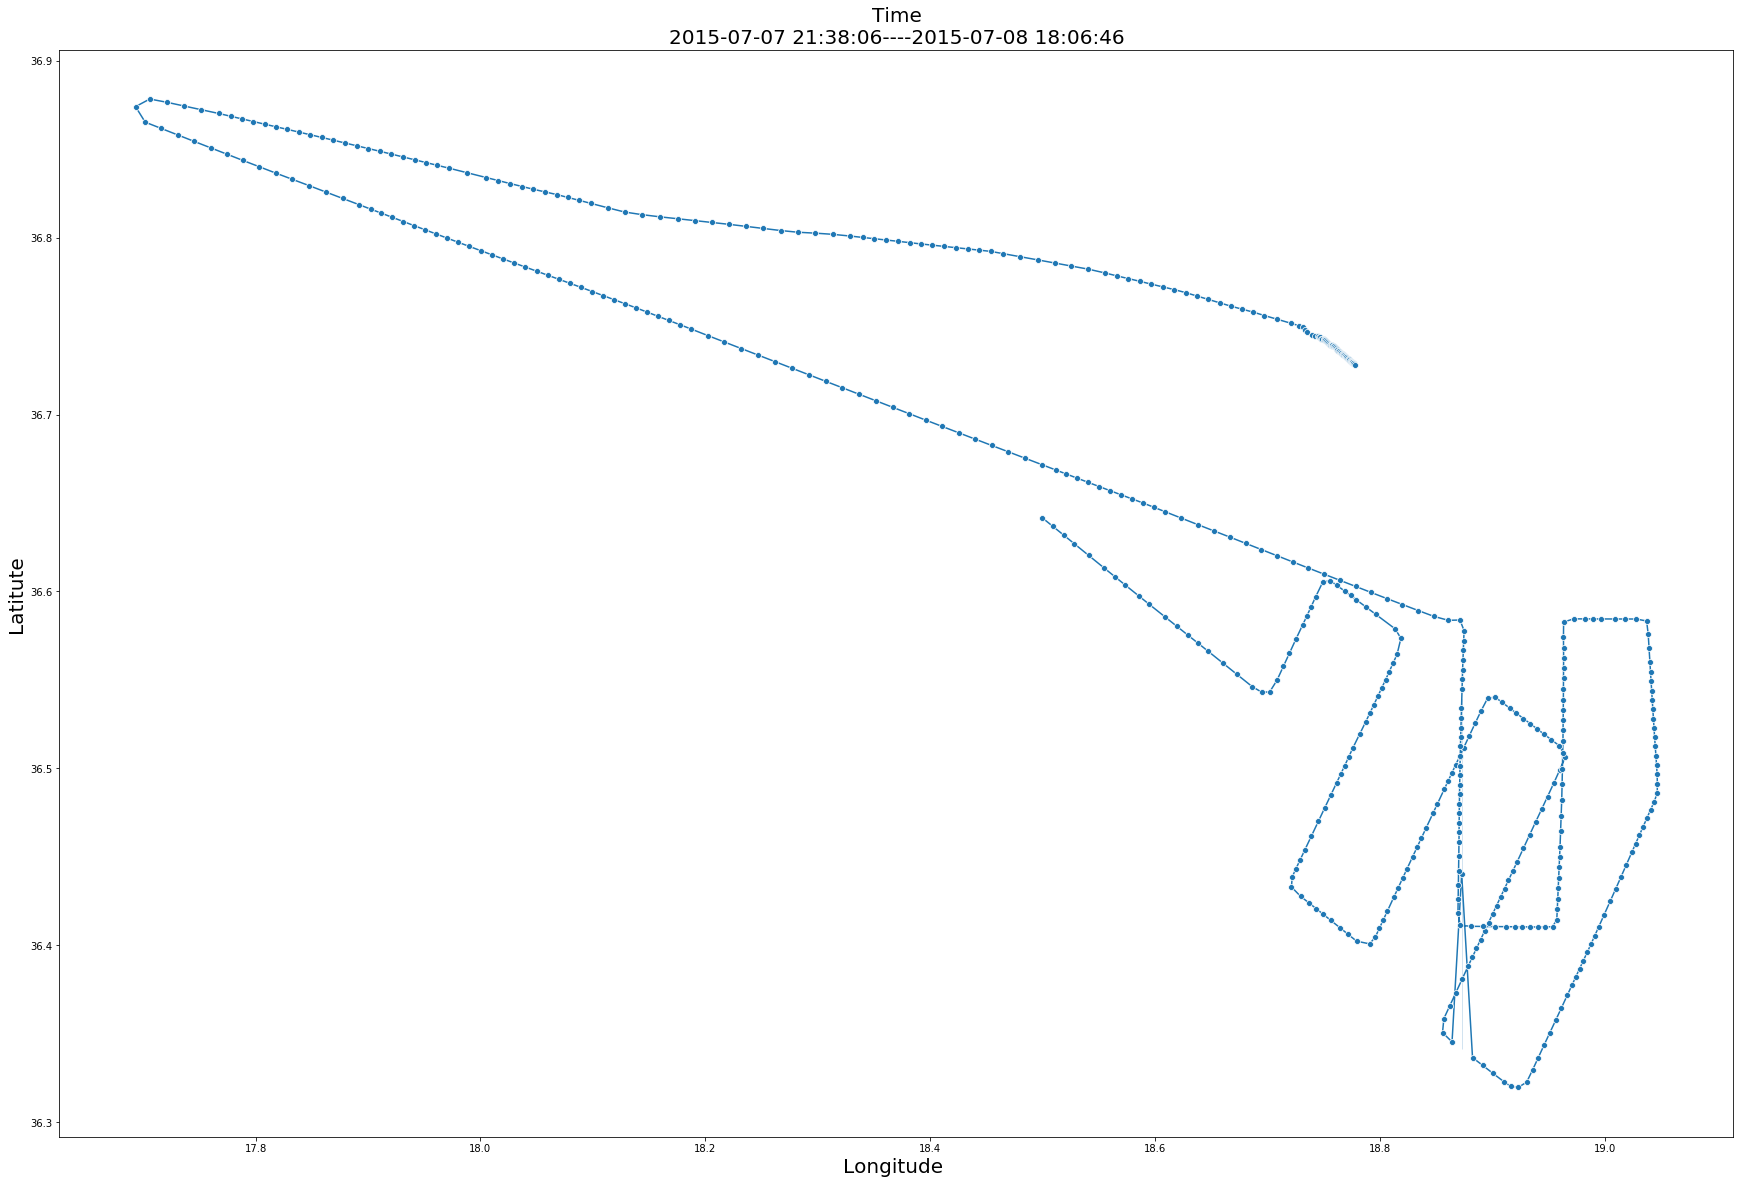

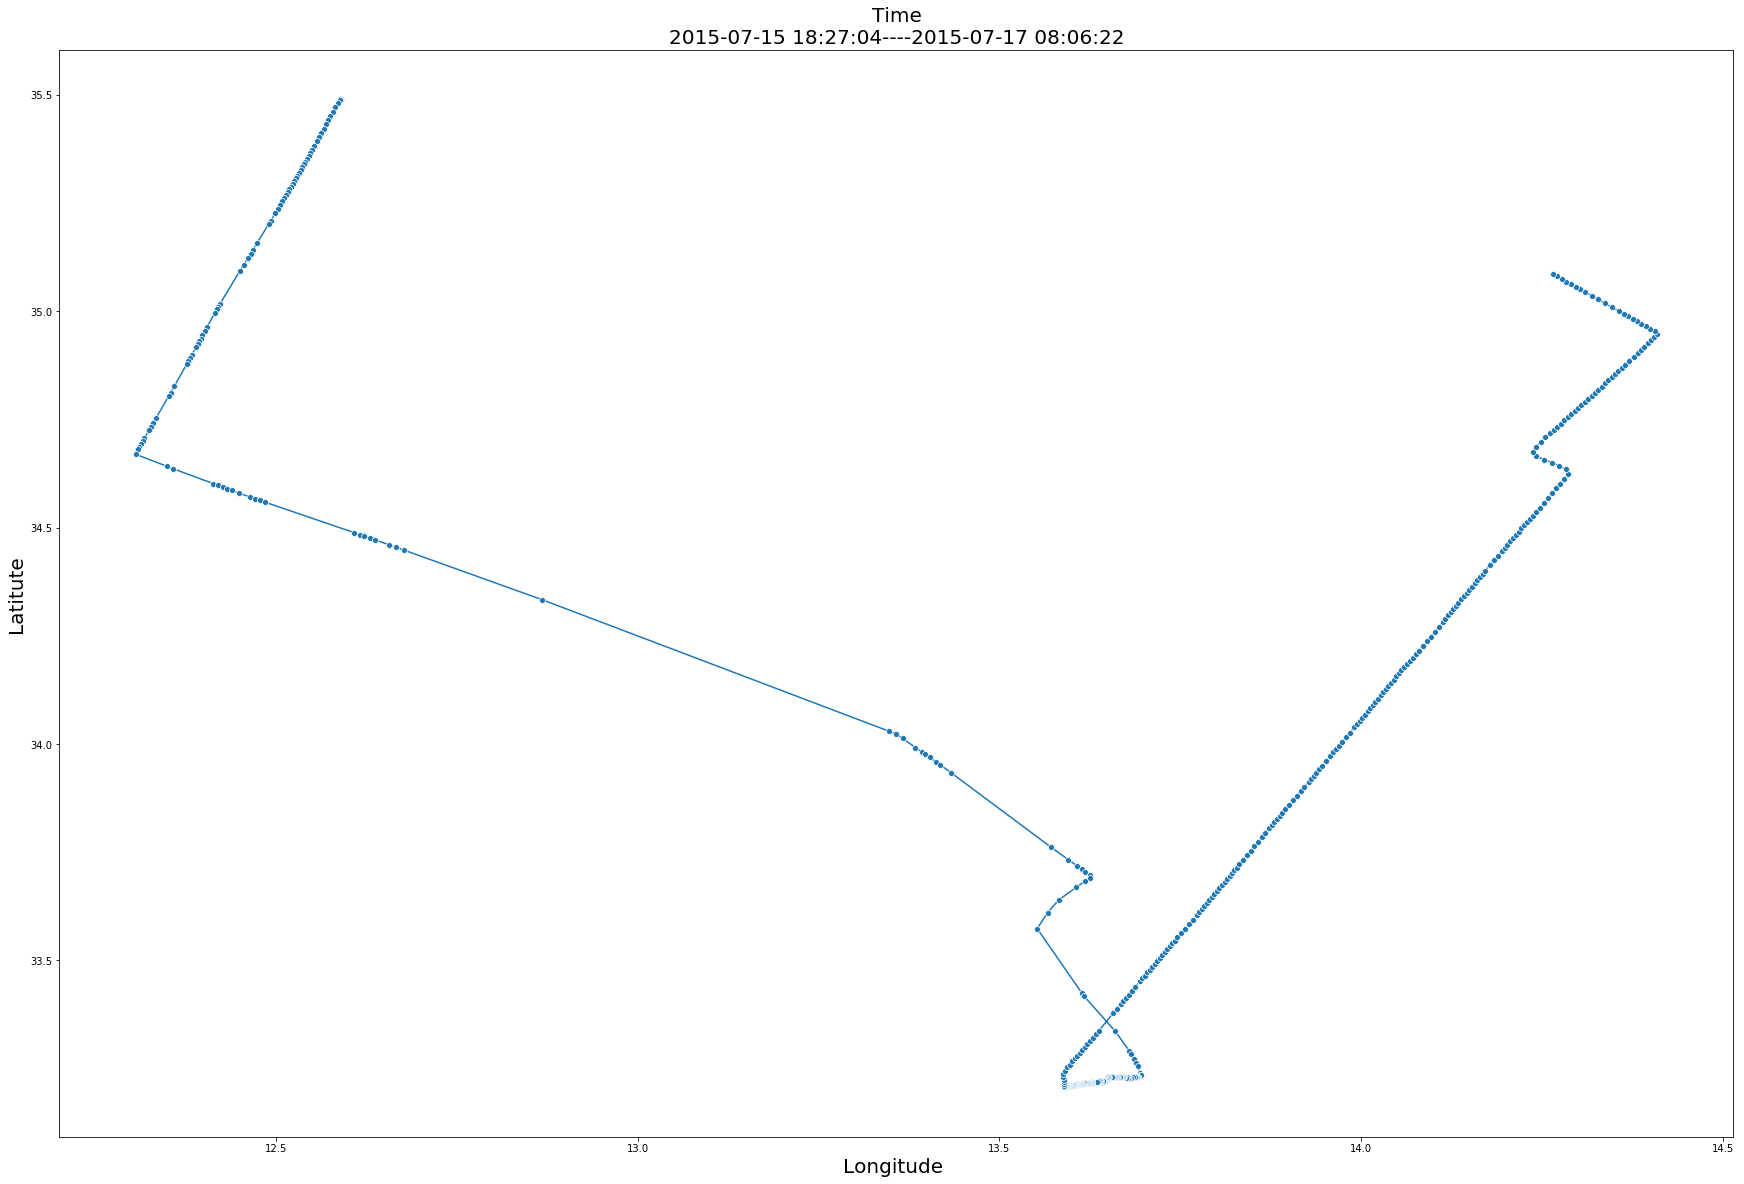

In [9]:
for p_ship in ship_dfs:
    fig, ax = plt.subplots()
    sns.lineplot(x='LON', y='LAT', data=p_ship, ax=ax,sort=False,marker="o")
    fig.set_size_inches(30, 20)
    ax.set_ylabel('Latitute', fontsize = 20.0) # Y label
    ax.set_xlabel('Longitude ', fontsize = 20.0) # X label
    start = datetime.strftime(p_ship["TIMESTAMP"].head(1).iloc[0],'%Y-%m-%d %H:%M:%S')
    end = datetime.strftime(p_ship["TIMESTAMP"].tail(1).iloc[0],'%Y-%m-%d %H:%M:%S')
    title = "Time\n"+start+"----"+end
    ax.set_title(title,fontsize = 20.0)

<div><b><i>SIEM PILOT full trajectory:</i></b>
    <ul><b>First case :</b> check for a known case of pattern (creeping_line_left for SIEM PILOT ship) if the result of classification is right with the use of normal settings</ul> </div>

for chunk 2 and pattern step_up_left a prediction is made with probability 0.8780005058665915
for chunk 0 and pattern step_up_right a prediction is made with probability 0.9065530951807093
for chunk 1 and pattern step_up_right a prediction is made with probability 0.7164005332147614
for chunk 2 and pattern step_up_right a prediction is made with probability 0.9845281654320907
for chunk 3 and pattern step_up_right a prediction is made with probability 0.8268817510228891
for chunk 1 and pattern sector_pattern_left a prediction is made with probability 0.5618298086794598
1 times of pattern detection: step_up_left  at indexes  [2]
4 times of pattern detection: step_up_right  at indexes  [0, 1, 2, 3]
0 times of pattern detection: spiral_movement_left  at indexes  []
0 times of pattern detection: spiral_movement_right  at indexes  []
0 times of pattern detection: expanding_square_left  at indexes  []
0 times of pattern detection: expanding_square_right  at indexes  []
0 times of pattern dete

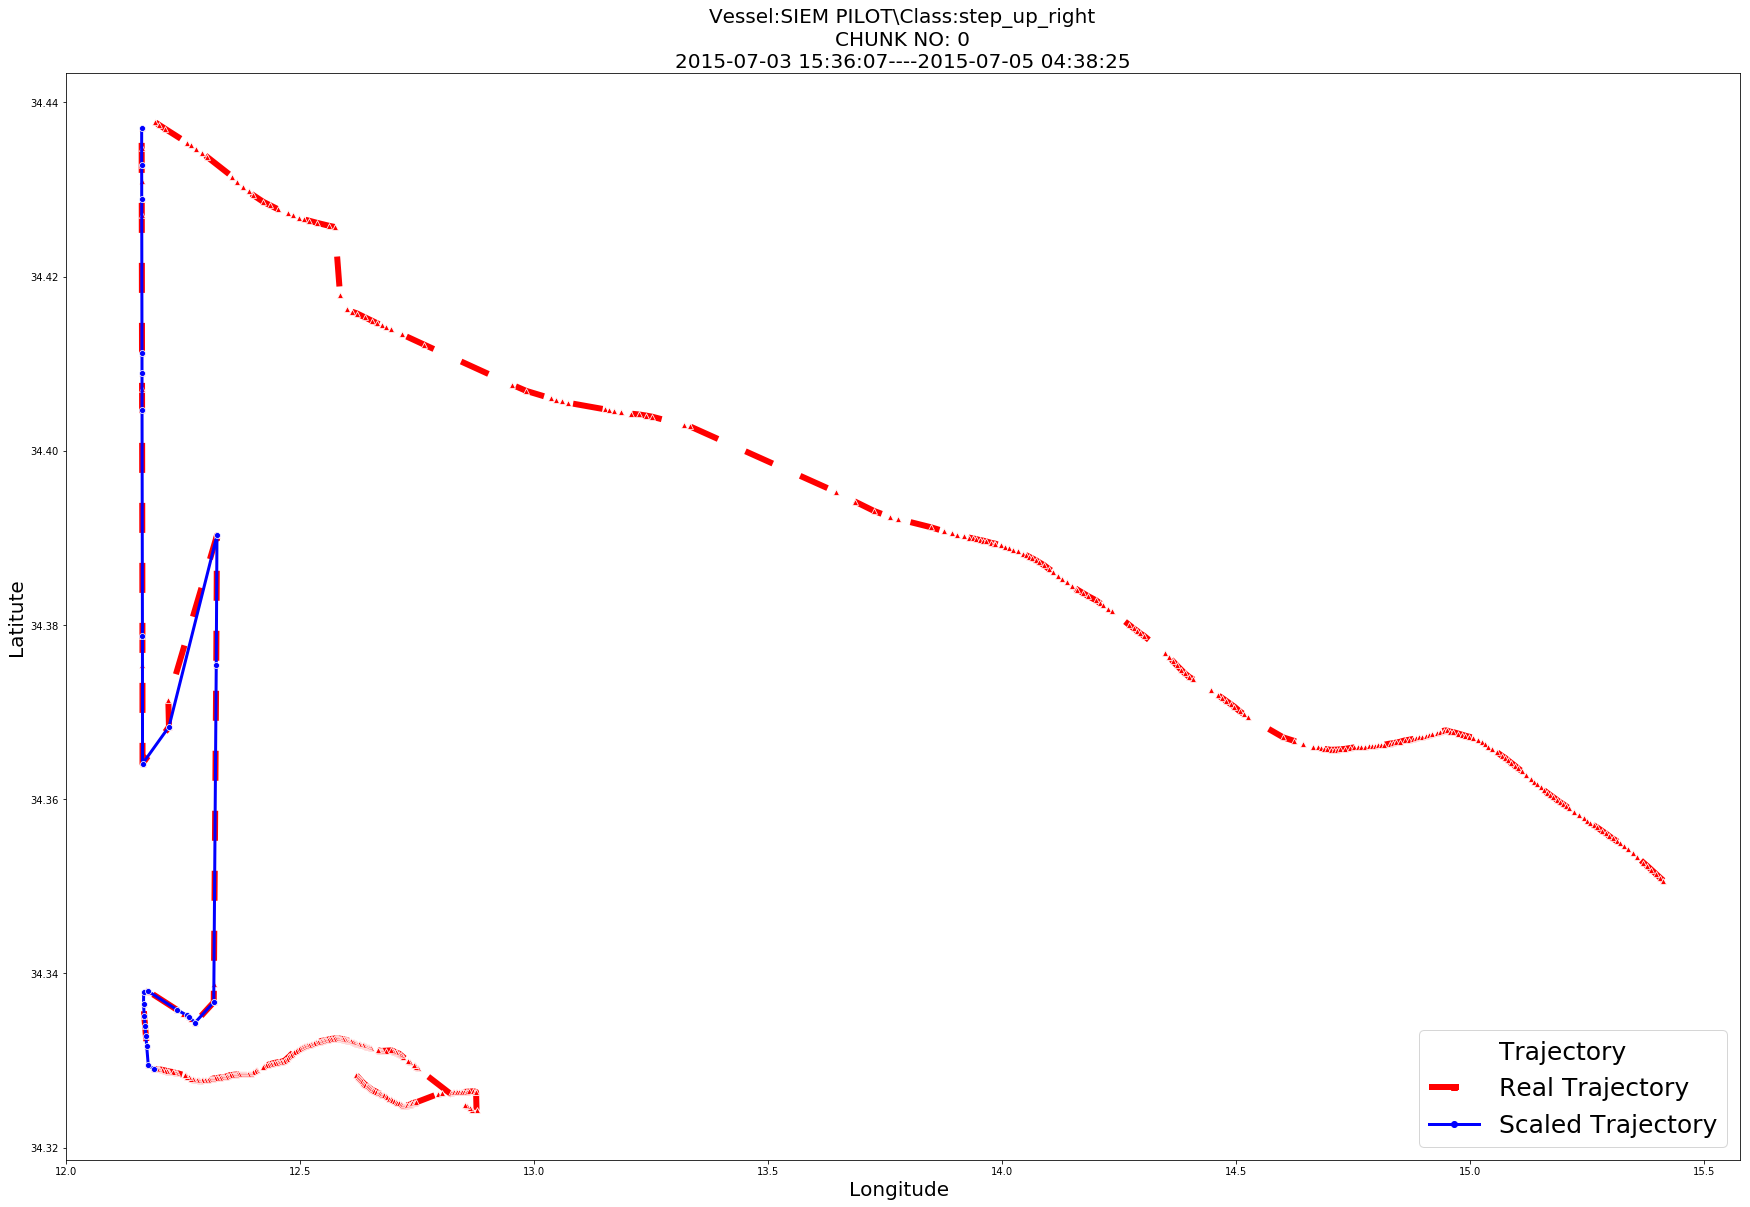

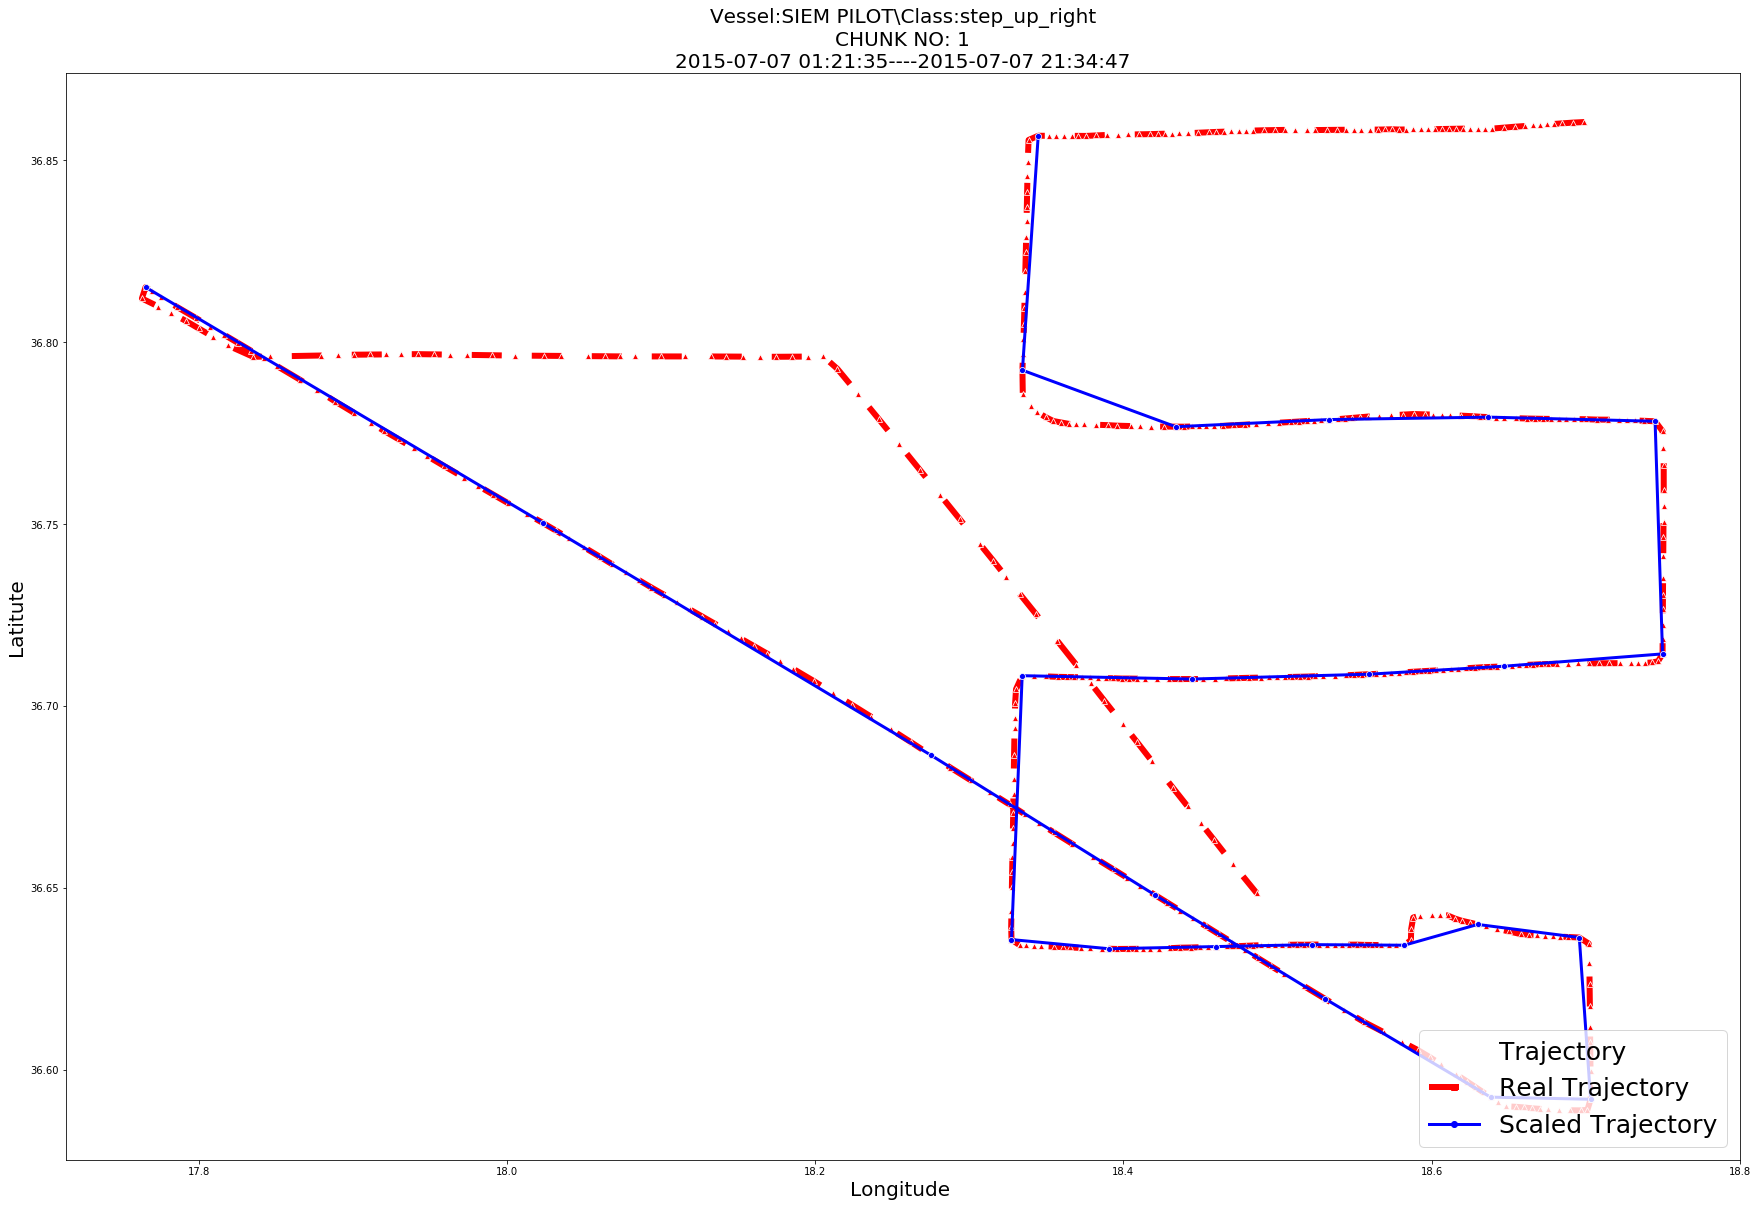

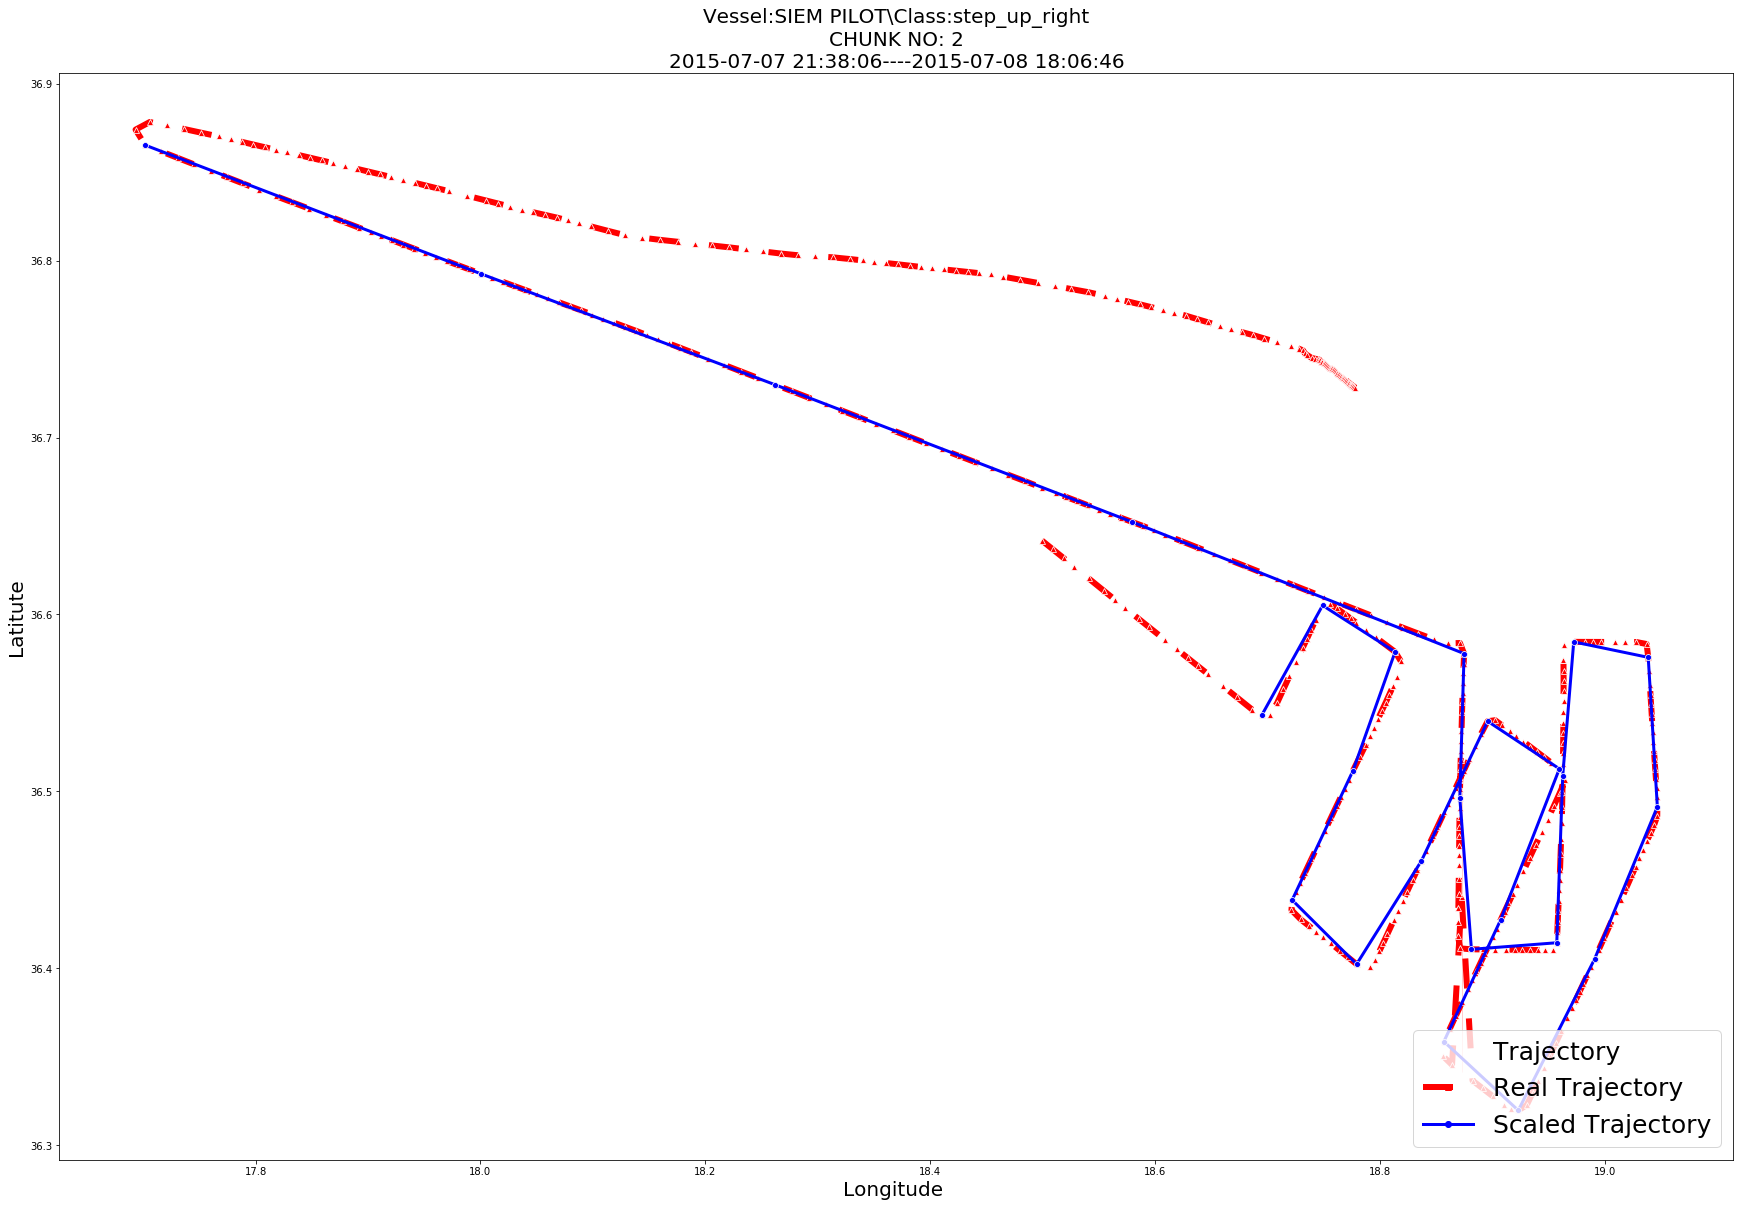

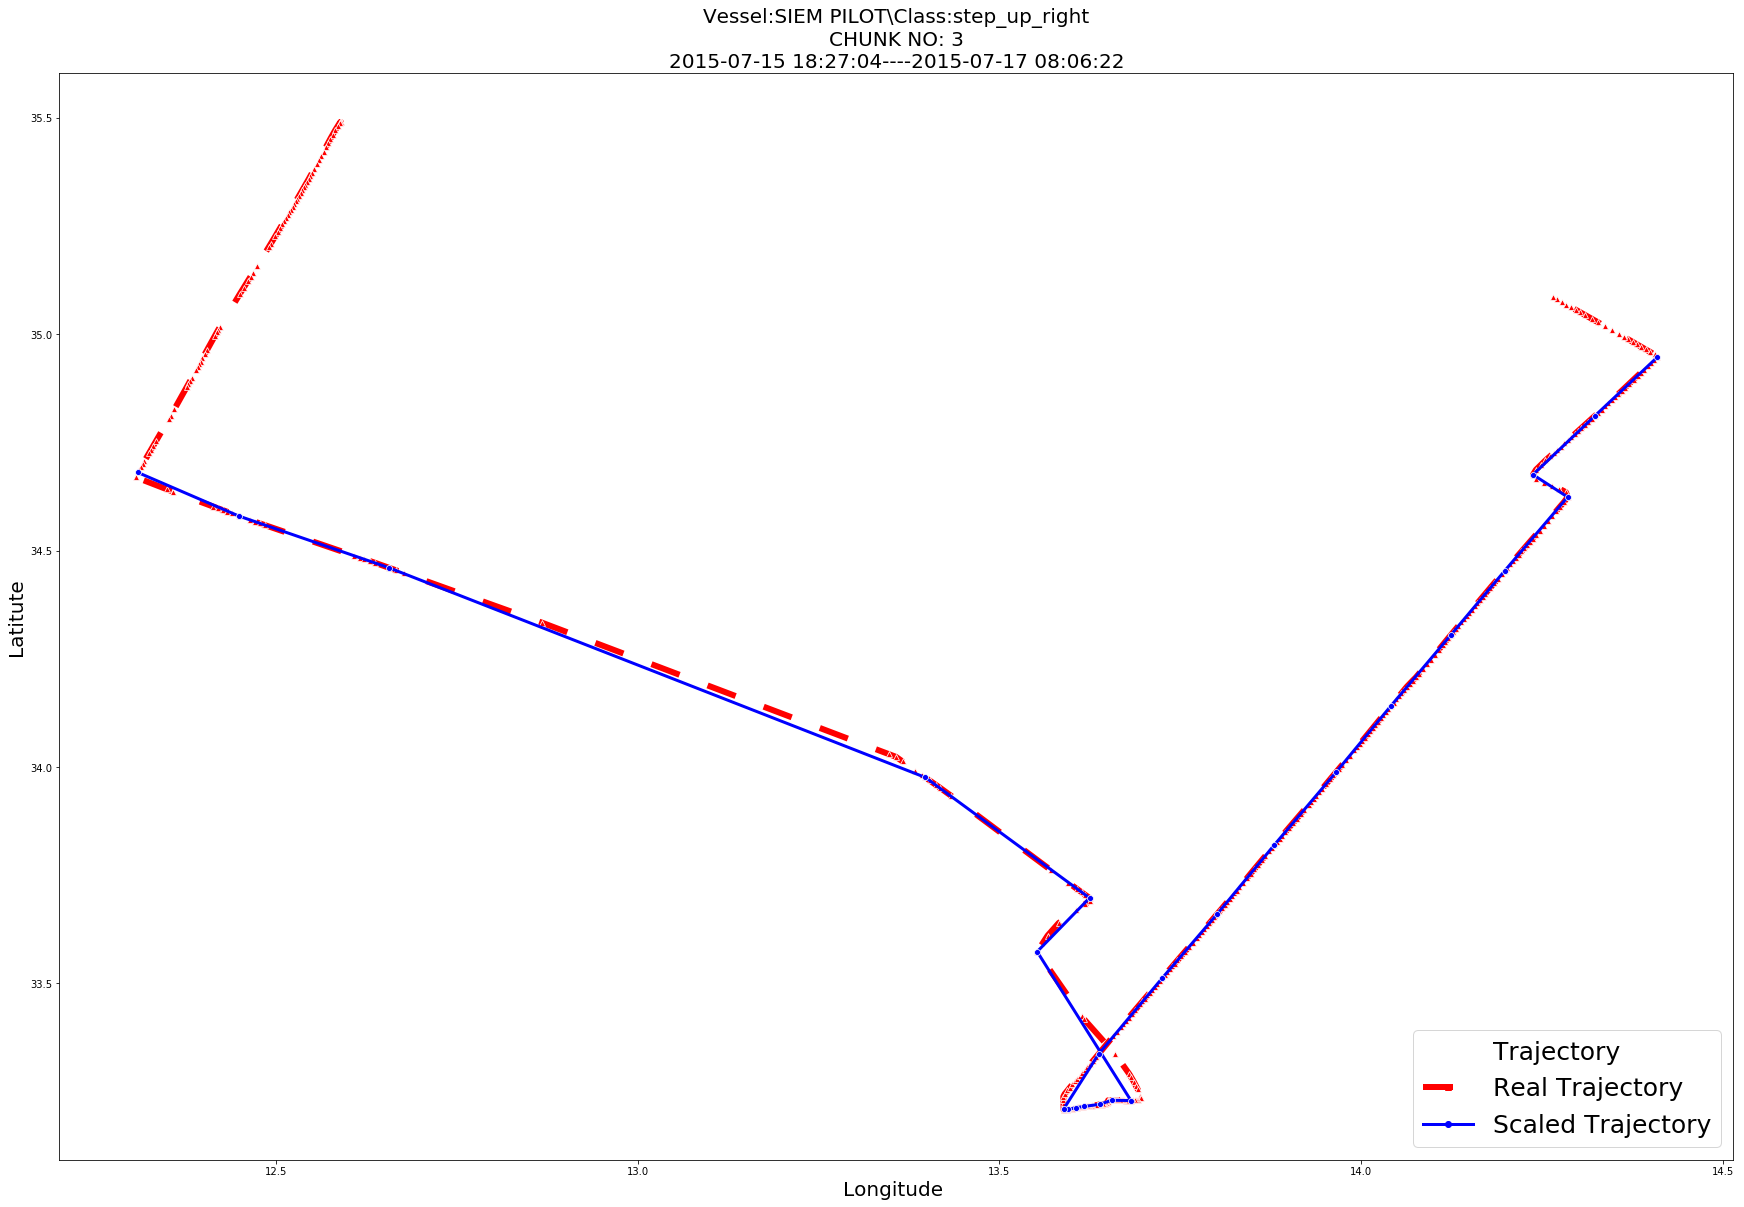

In [10]:
predictions,proba = experiments(ship,movement_list)
print_results(movement_list,predictions,proba)
proba_info,pattern_indexes = results(movement_list,proba,predictions)
best_patterns = find_best_patterns(proba_info)
plots(movement_list=movement_list,
      pattern_indexes=pattern_indexes,
      best_patterns=best_patterns,
      ship_name=ship["shipname"],
      ship_dfs=ship["ship_dfs"])

<div><b><i>SIEM PILOT full trajectory:</i></b>
    <ul><b>Second case :</b> check for a known case of pattern (creeping_line_left for SIEM PILOT ship) if the result of classification is right with the use of rdp algorithm before the scale_down section</ul>

Chunk from 1000 to 1499
Size of chunk after rdp: 368
scale down successful
0 times of pattern detection: step_up_left  at indexes  []
0 times of pattern detection: step_up_right  at indexes  []
0 times of pattern detection: spiral_movement_left  at indexes  []
0 times of pattern detection: spiral_movement_right  at indexes  []
0 times of pattern detection: expanding_square_left  at indexes  []
0 times of pattern detection: expanding_square_right  at indexes  []
0 times of pattern detection: creeping_line_left  at indexes  []
0 times of pattern detection: creeping_line_right  at indexes  []
0 times of pattern detection: sector_pattern_left  at indexes  []
1 times of pattern detection: sector_pattern_right  at indexes  [0]
Chunk from 2500 to 2999
Size of chunk after rdp: 363
scale down successful
0 times of pattern detection: step_up_left  at indexes  []
0 times of pattern detection: step_up_right  at indexes  []
0 times of pattern detection: spiral_movement_left  at indexes  []
0 times 

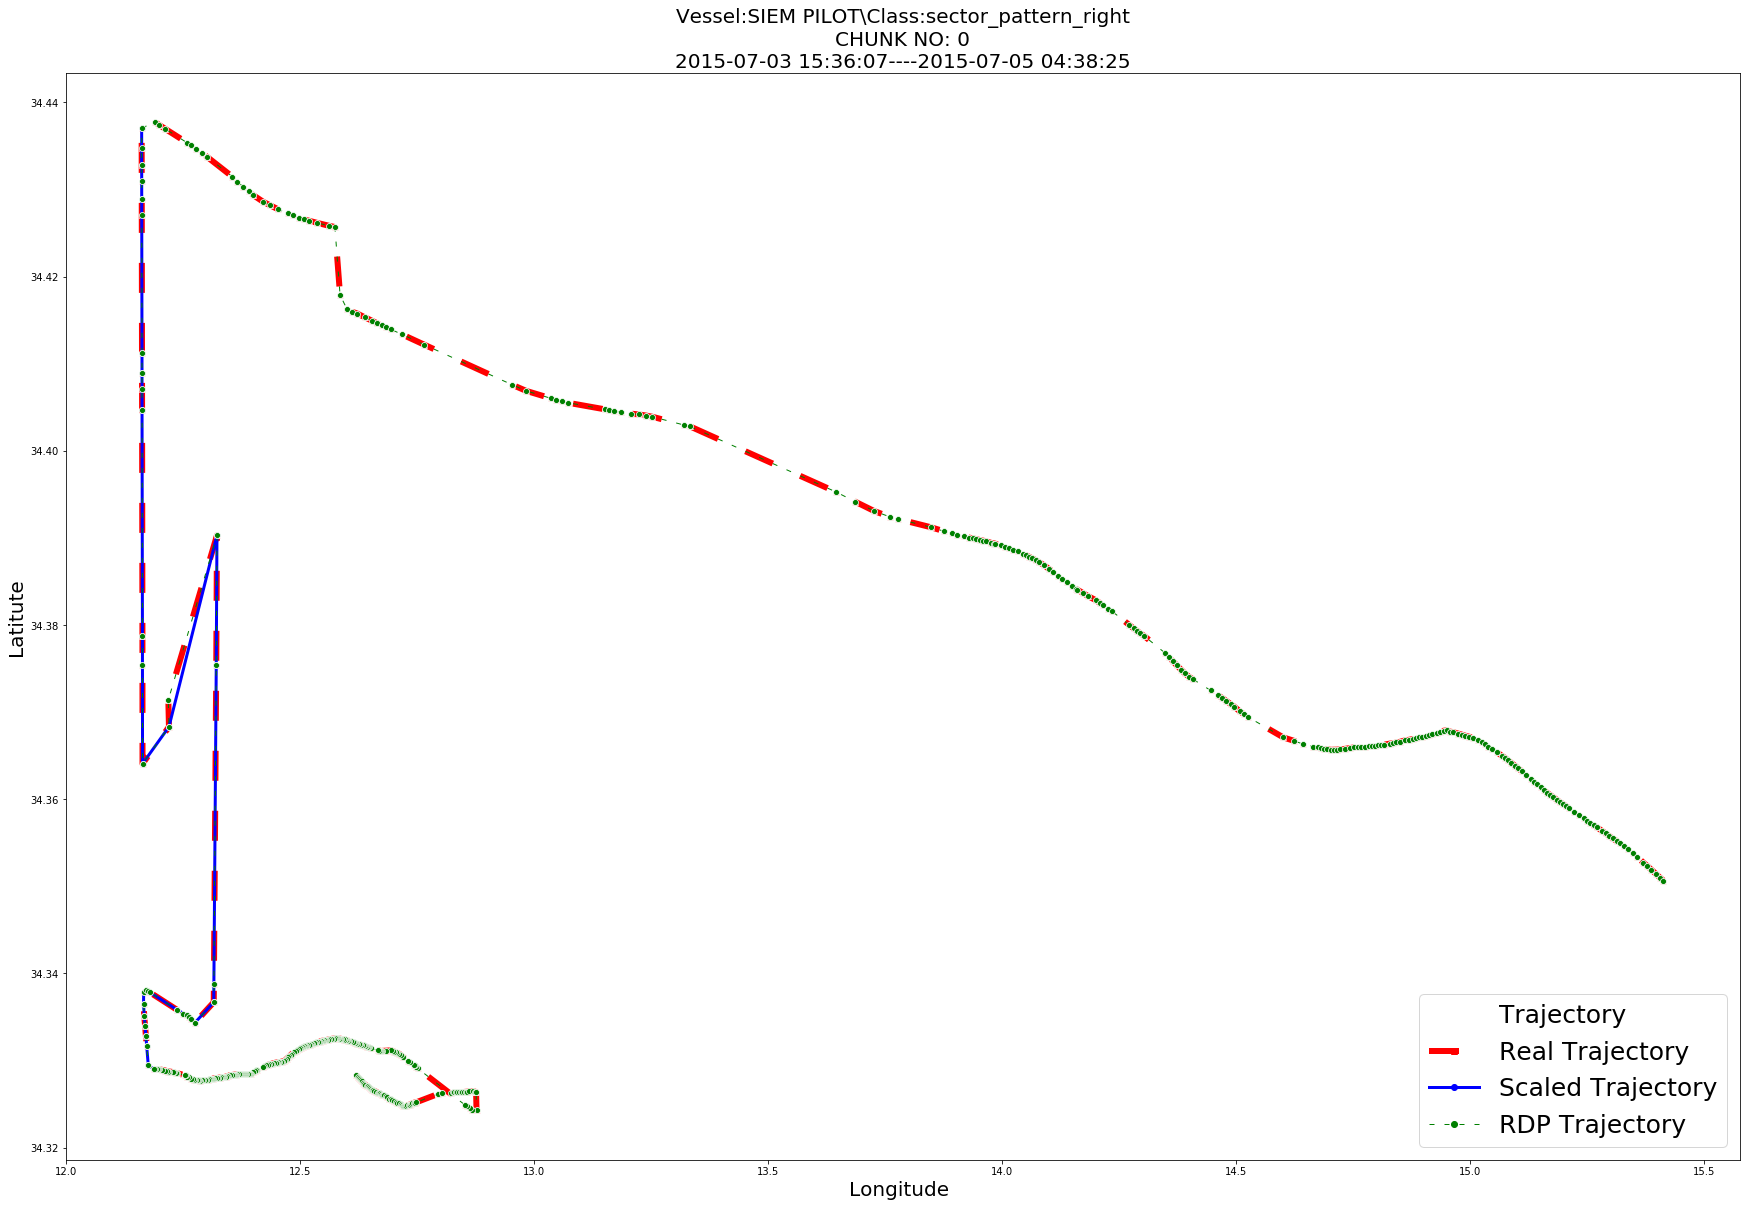

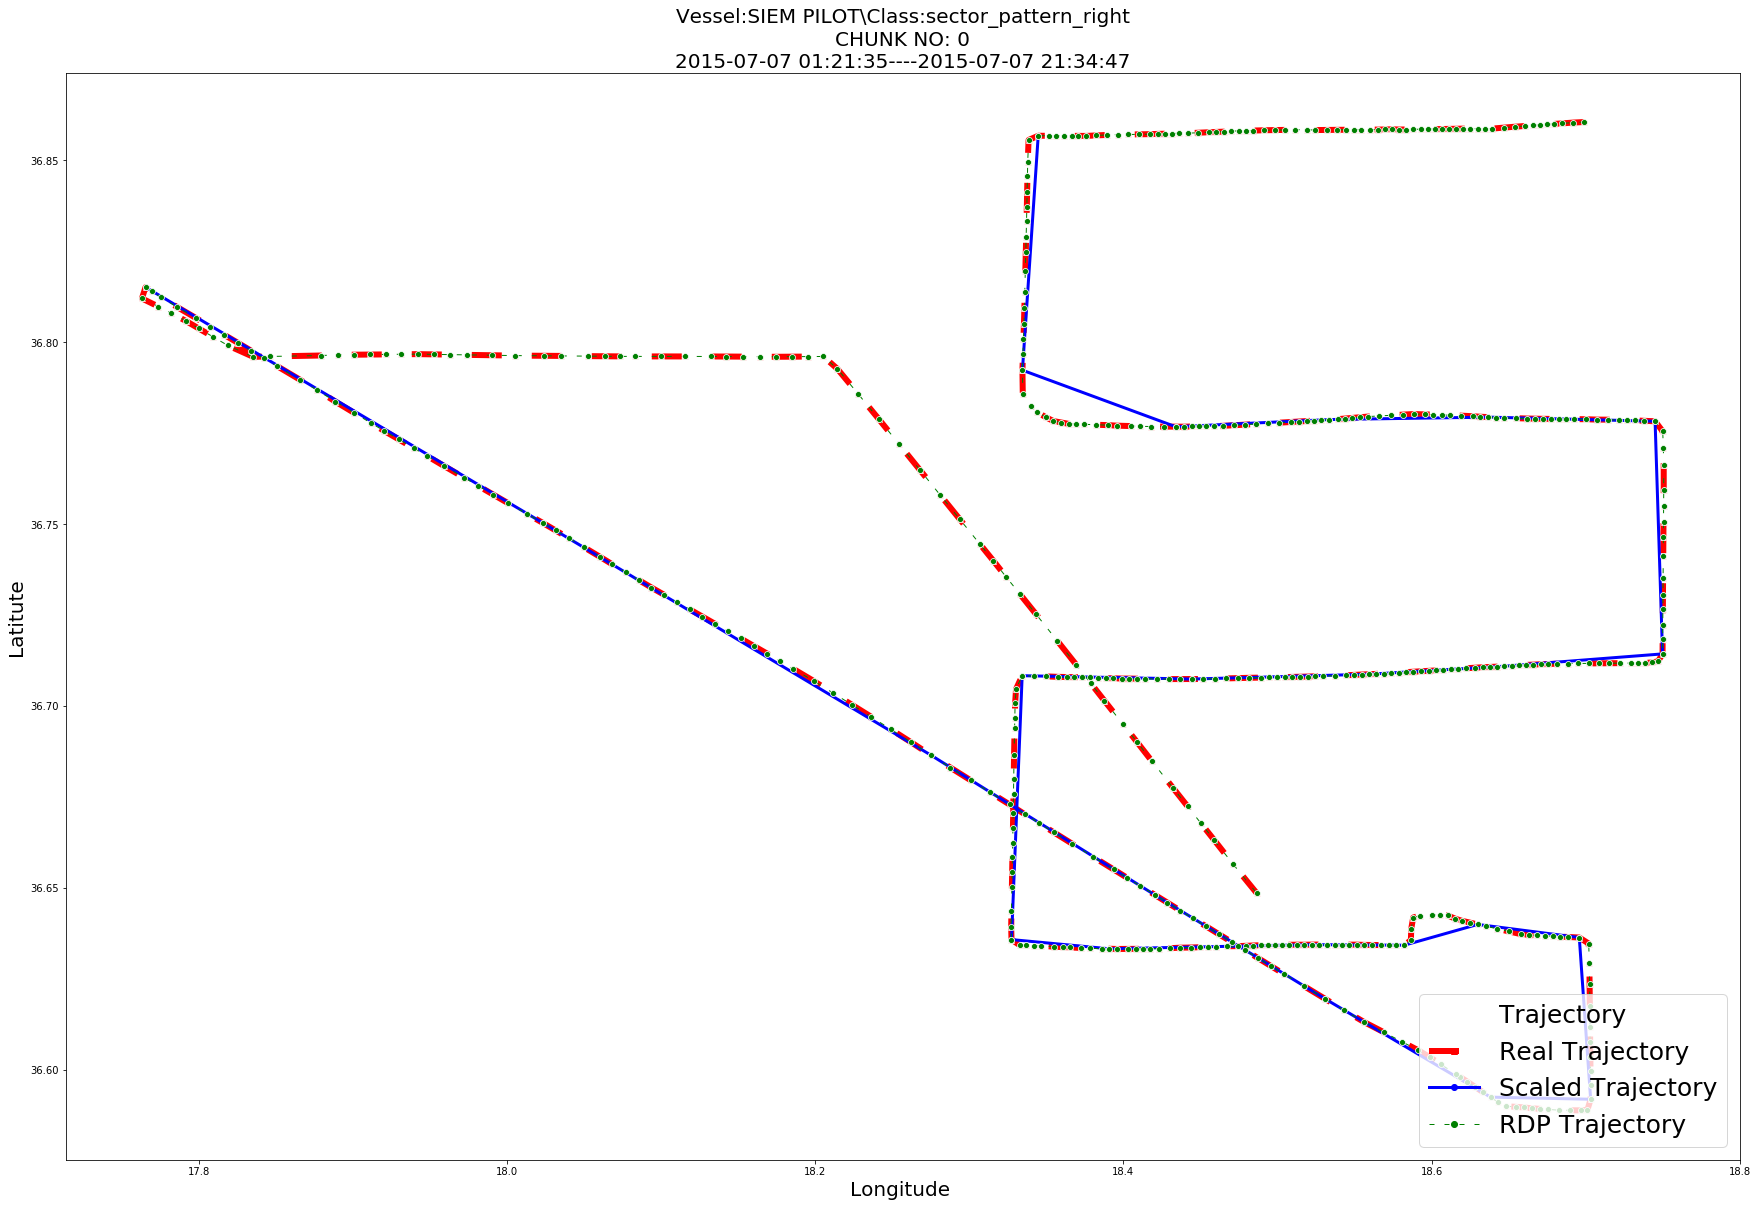

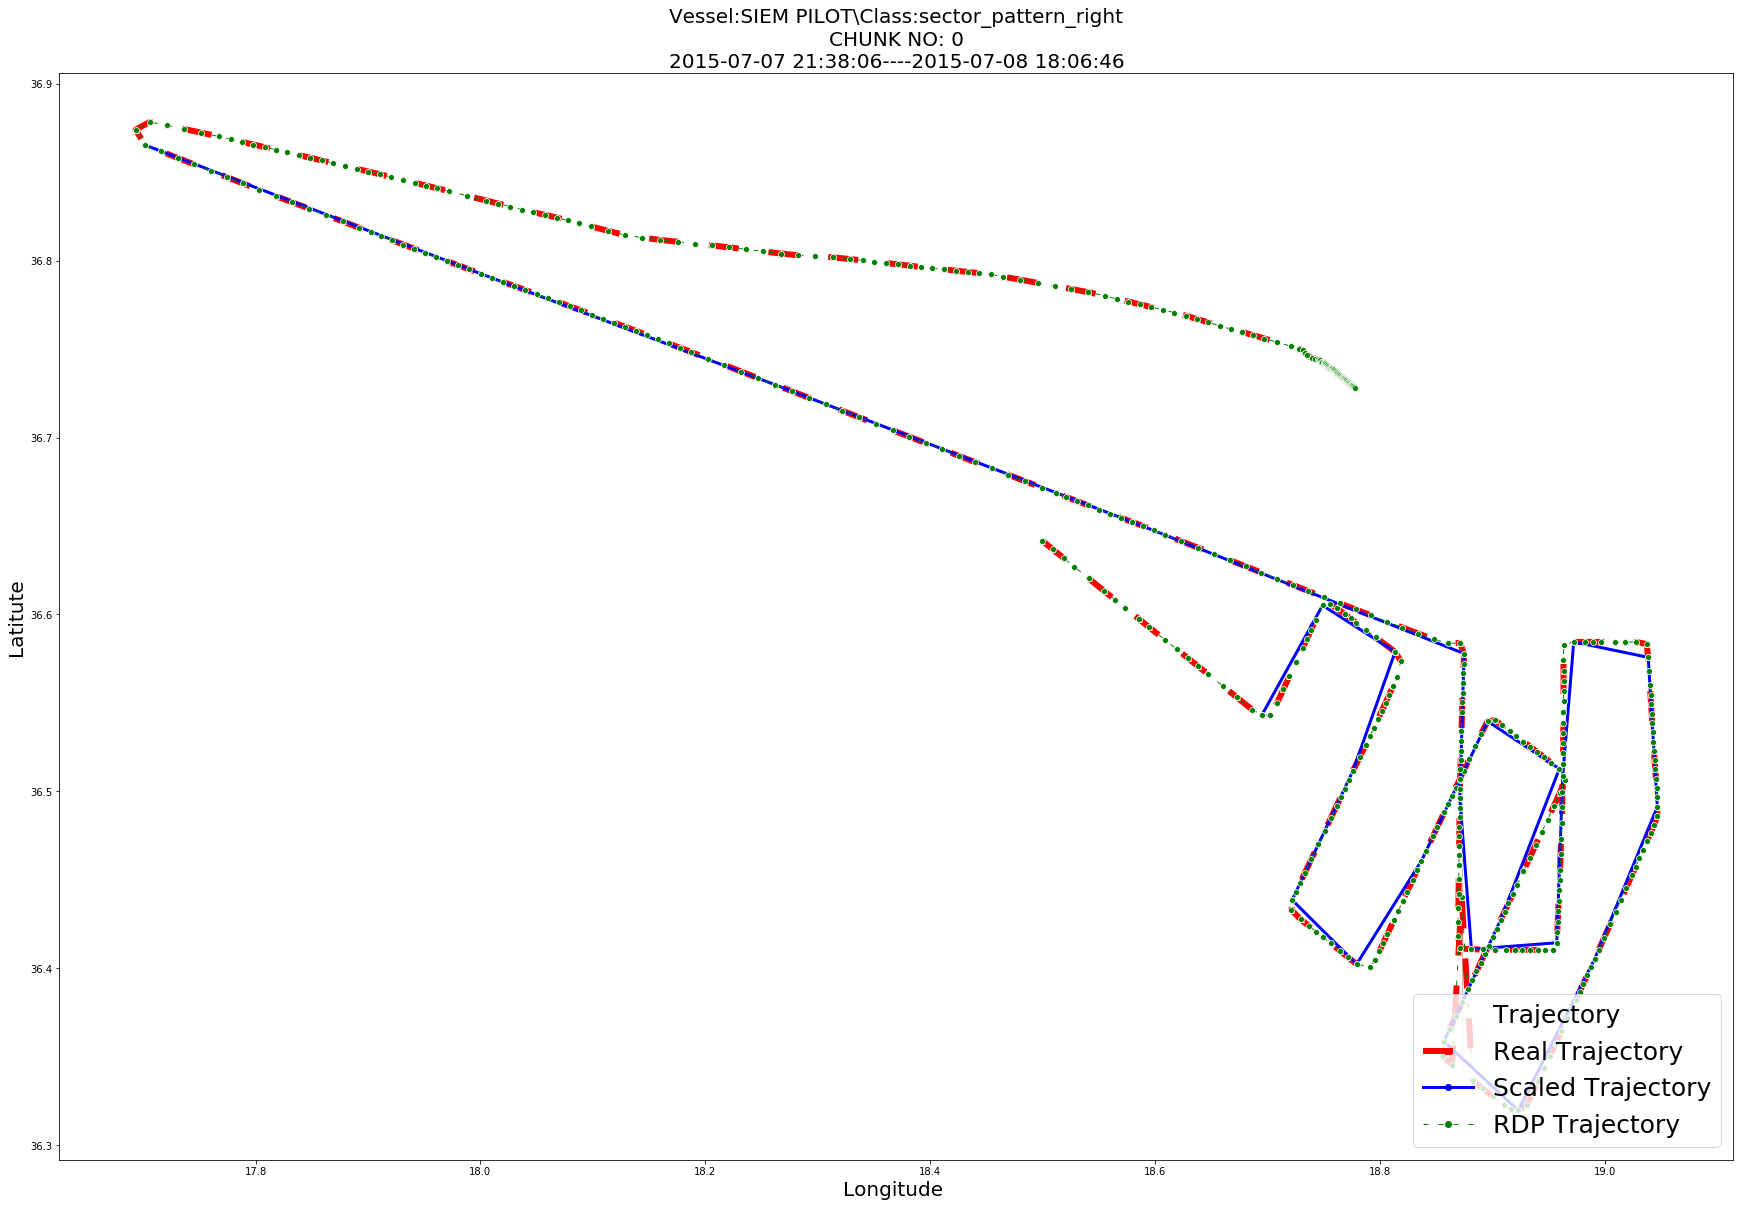

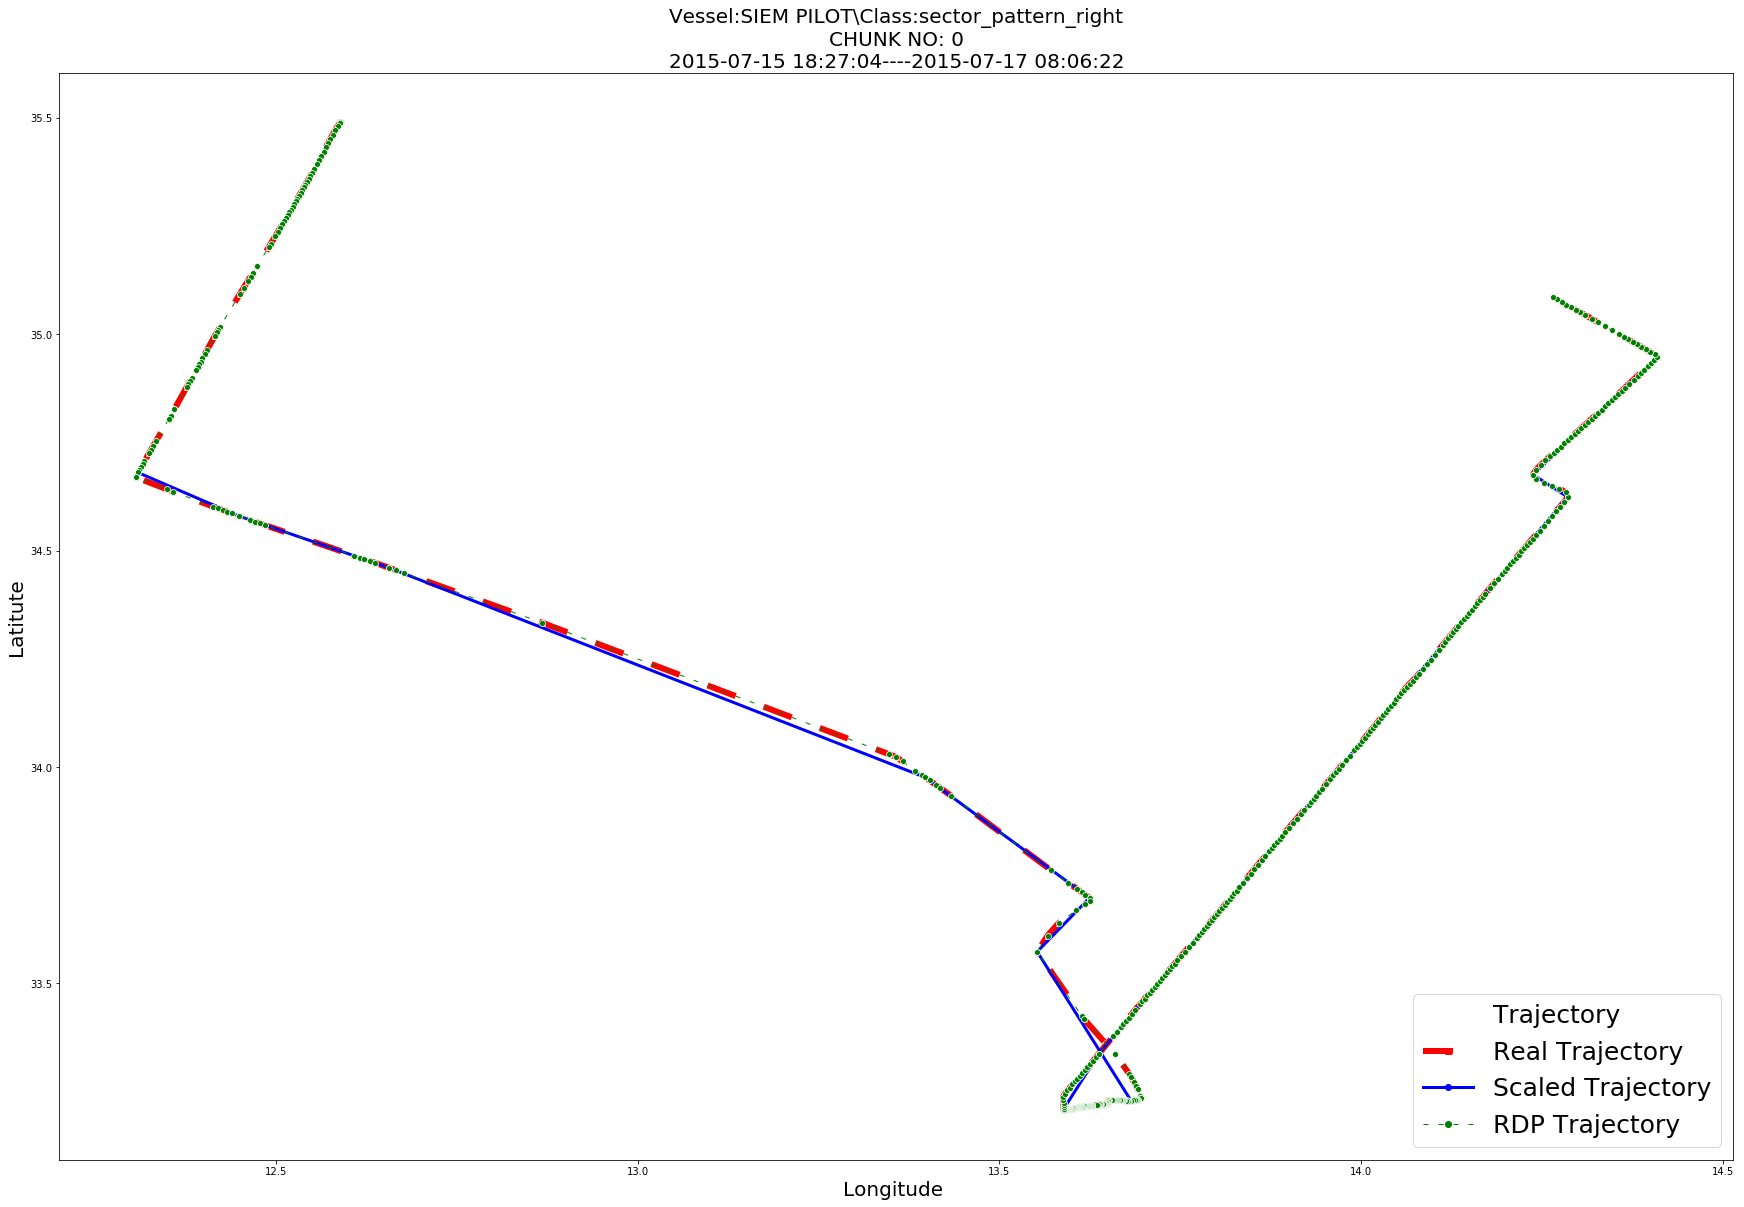

In [11]:
for x in ship_dfs:
    print("Chunk from {0} to {1}".format(x.index[0],x.index[-1]))
    lat = np.array(x["LAT"])
    lon = np.array(x["LON"])
    np_real_data = [np.array([x_lat,lon[idx]]) for idx,x_lat in enumerate(lat)]
    mask = rdp(np_real_data,algo="iter", return_mask=True,epsilon=0.000009)
    rdp_real_data =  x[mask]
    print("Size of chunk after rdp:",len(rdp_real_data))
    if len(rdp_real_data) > train_test_options["split"]:
        rdp_x = scale_down(rdp_real_data,train_test_options["split"])
        if len(rdp_x)==train_test_options["split"]:
            print("scale down successful")
            rdp_x = np.array([rdp_real_data["HEADING"].values.astype(int)])
            rdp_ship = {"shipname":"SIEM PILOT","data":rdp_x,"ship_dfs":[rdp_real_data]}
            rdp_predictions,rdp_proba = experiments(rdp_ship,movement_list)
            rdp_proba_info,rdp_pattern_indexes = results(movement_list,rdp_proba,rdp_predictions)
            rdp_best_patterns = find_best_patterns(rdp_proba_info)
            plots(movement_list=movement_list,
                  pattern_indexes=rdp_pattern_indexes,
                  best_patterns=rdp_best_patterns,
                  ship_name=rdp_ship["shipname"],
                  ship_dfs=[x],
                  rdp_data=rdp_real_data
                 )


<div><b><i>SIEM PILOT full trajectory:</i></b>
    <ul><b>Third case :</b> check for a known case of pattern (creeping_line_left for SIEM PILOT ship) if the result of classification is right with chunks with size 180-sample(50-sample size are too abstract to pass scale-down) (from a trajectory with size 500-sample) using scale-down </ul>

Chunk from 1000 to 1499
for chunk 0 and pattern step_up_right a prediction is made with probability 0.9027581182911902
0 times of pattern detection: step_up_left  at indexes  []
1 times of pattern detection: step_up_right  at indexes  [0]
0 times of pattern detection: spiral_movement_left  at indexes  []
0 times of pattern detection: spiral_movement_right  at indexes  []
0 times of pattern detection: expanding_square_left  at indexes  []
0 times of pattern detection: expanding_square_right  at indexes  []
0 times of pattern detection: creeping_line_left  at indexes  []
0 times of pattern detection: creeping_line_right  at indexes  []
0 times of pattern detection: sector_pattern_left  at indexes  []
0 times of pattern detection: sector_pattern_right  at indexes  []
Chunk from 2500 to 2999
for chunk 0 and pattern sector_pattern_left a prediction is made with probability 0.7997886766951645
for chunk 0 and pattern sector_pattern_right a prediction is made with probability 0.825153094114804

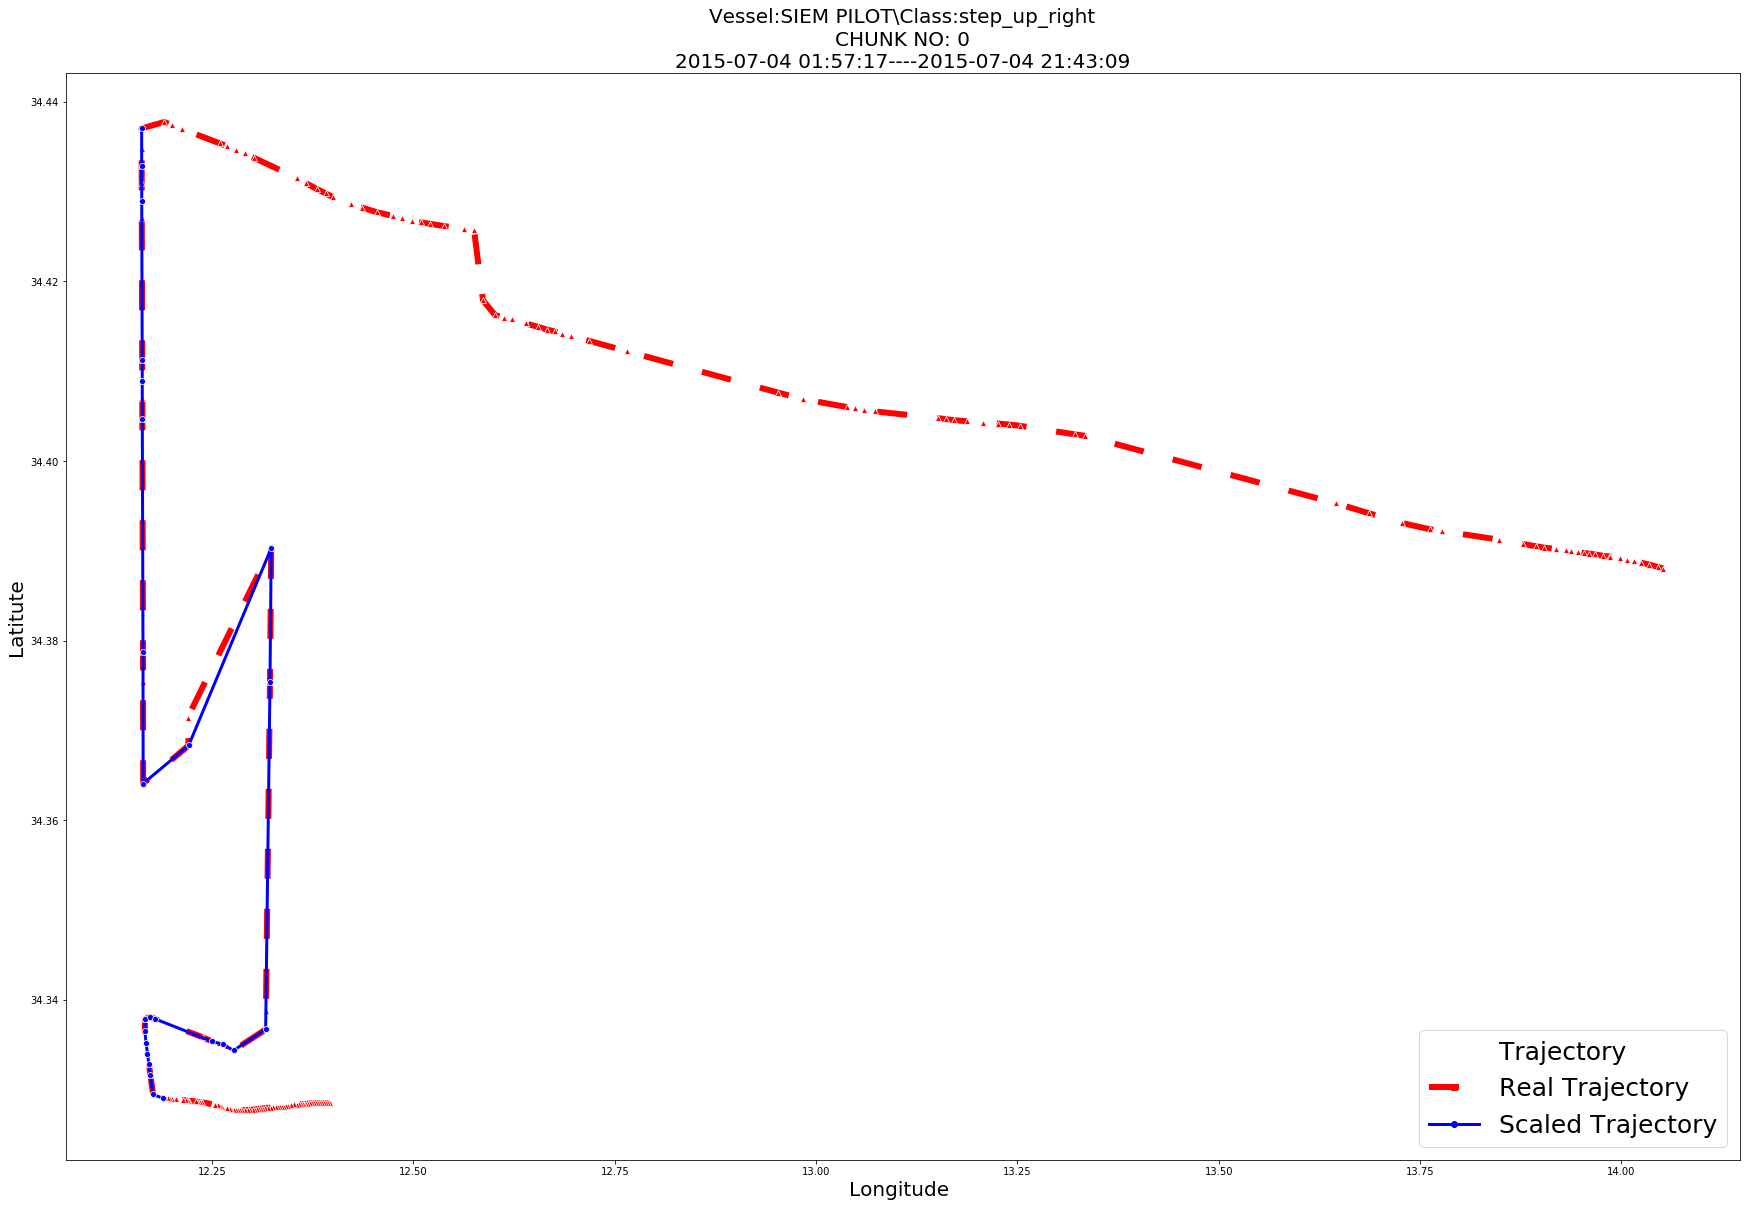

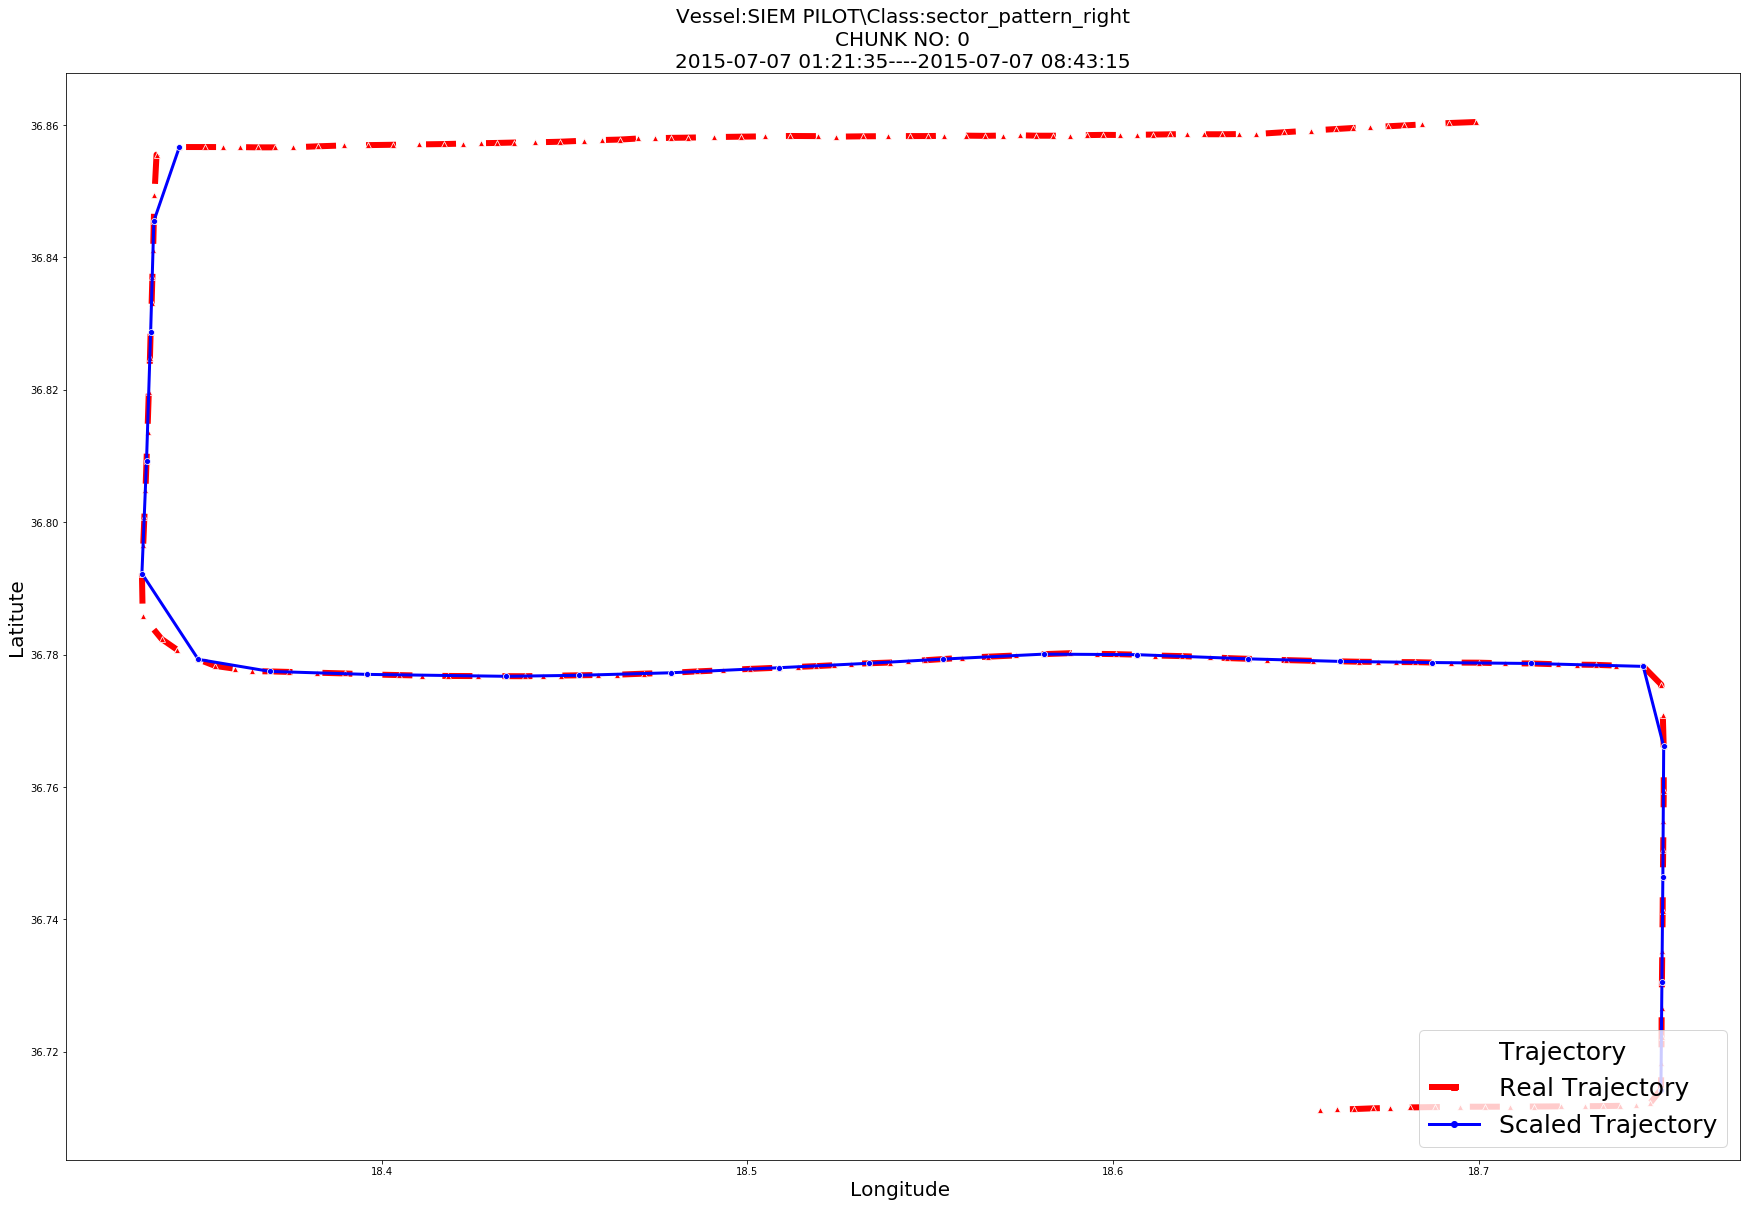

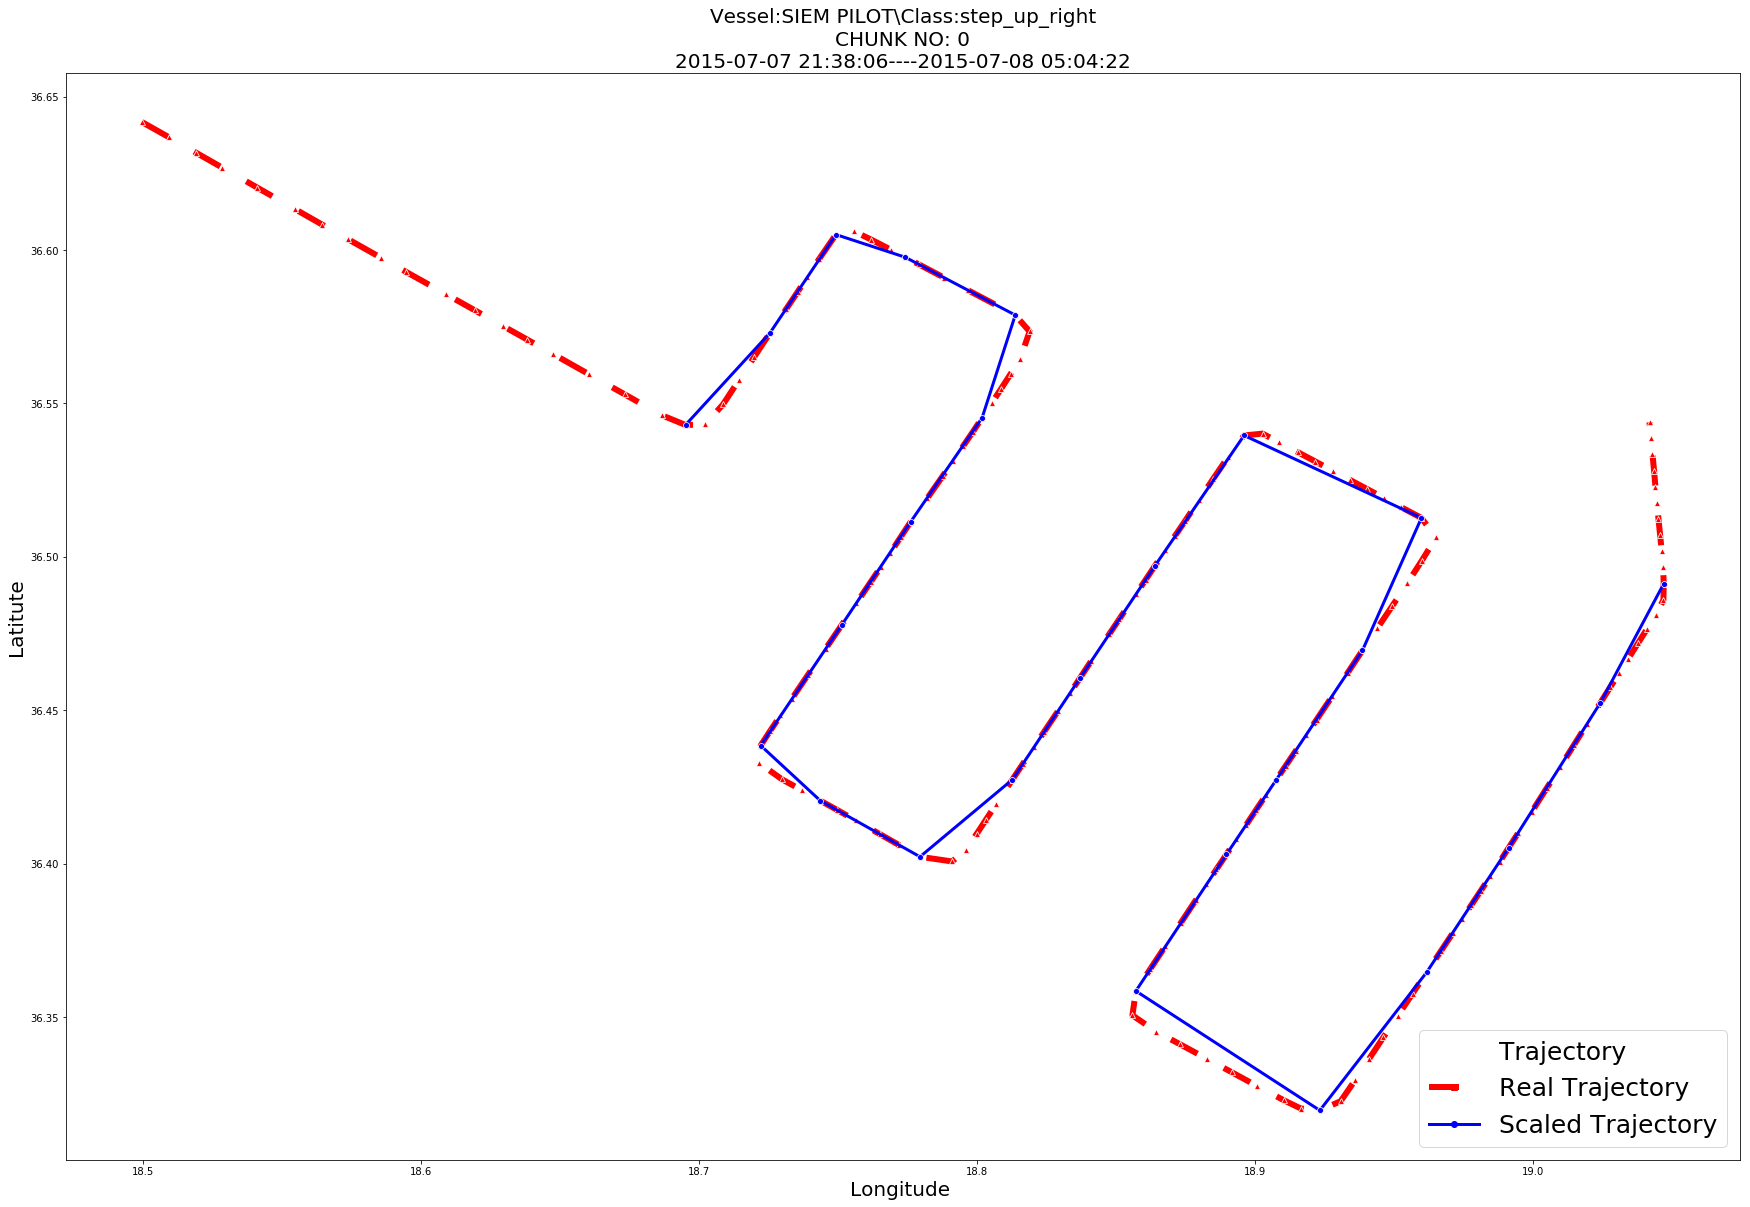

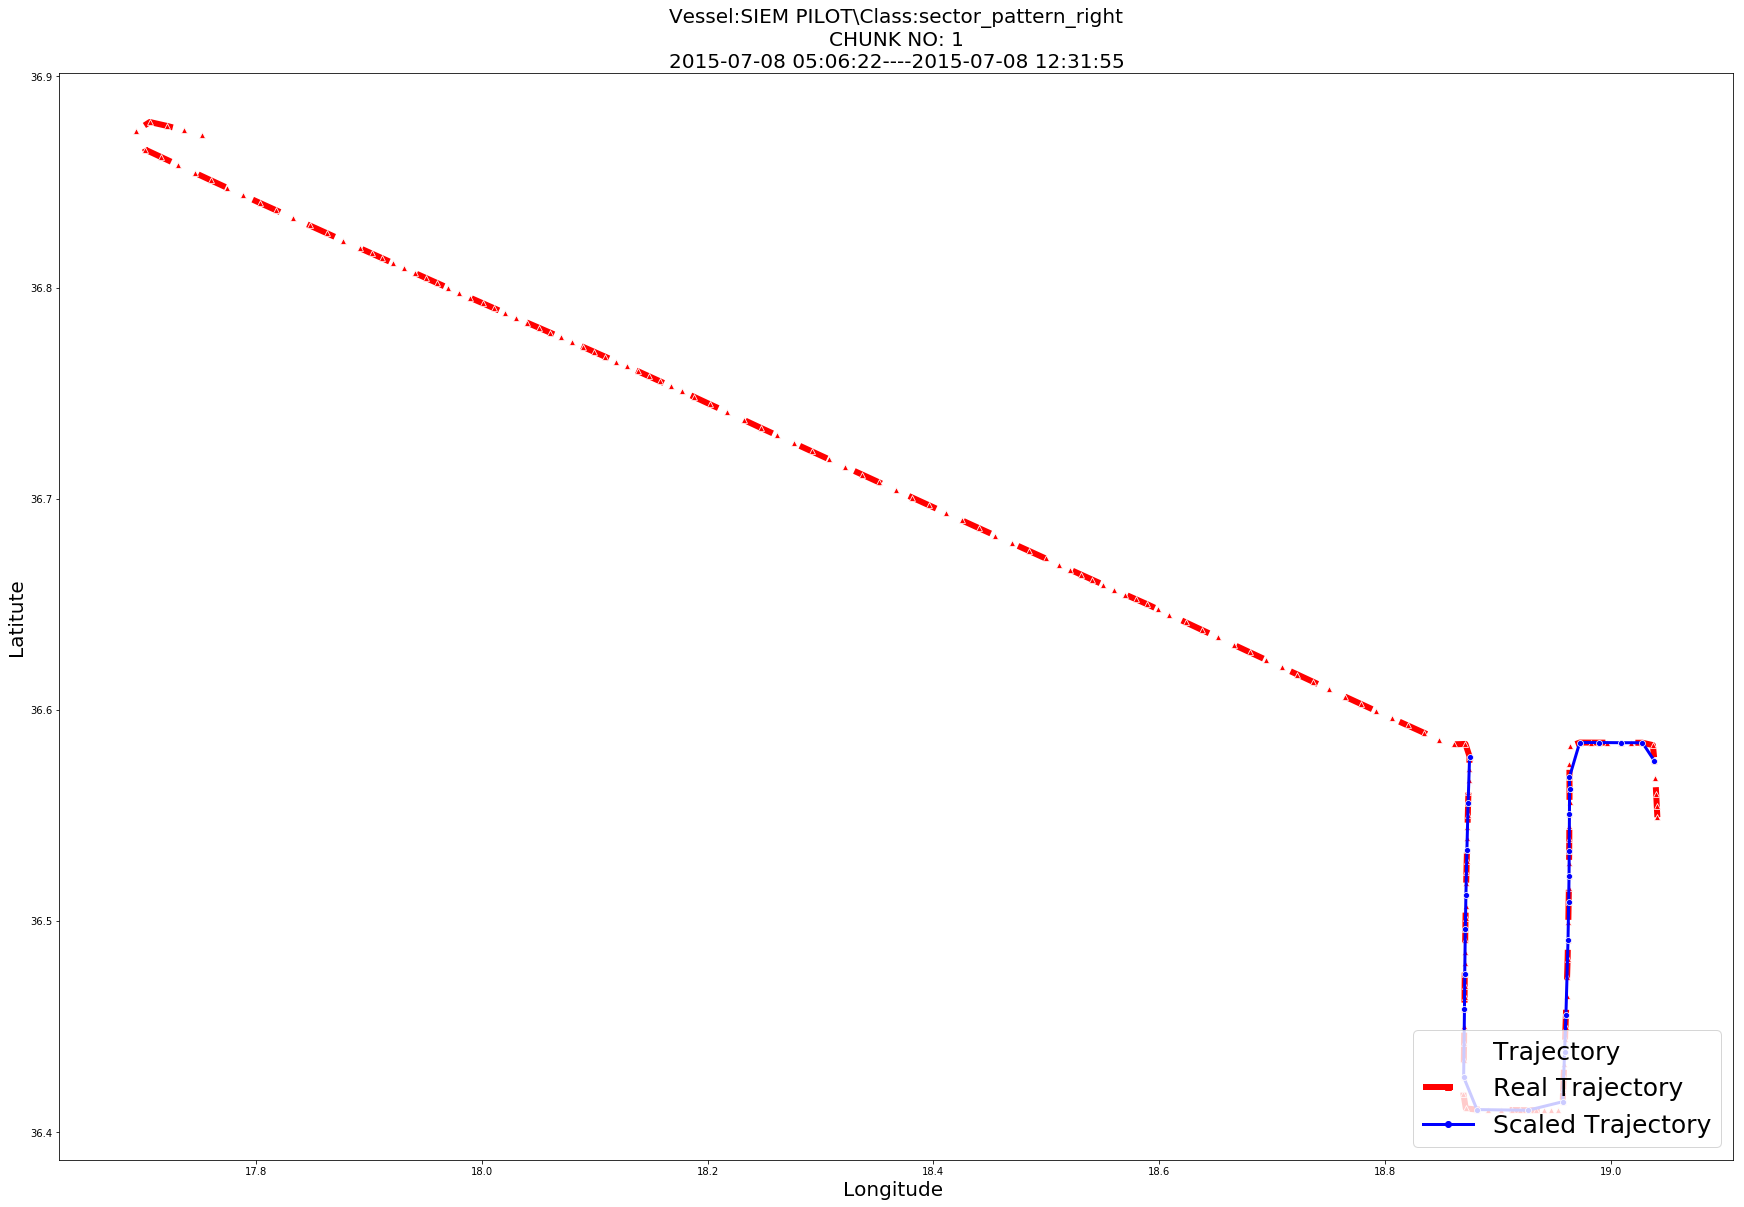

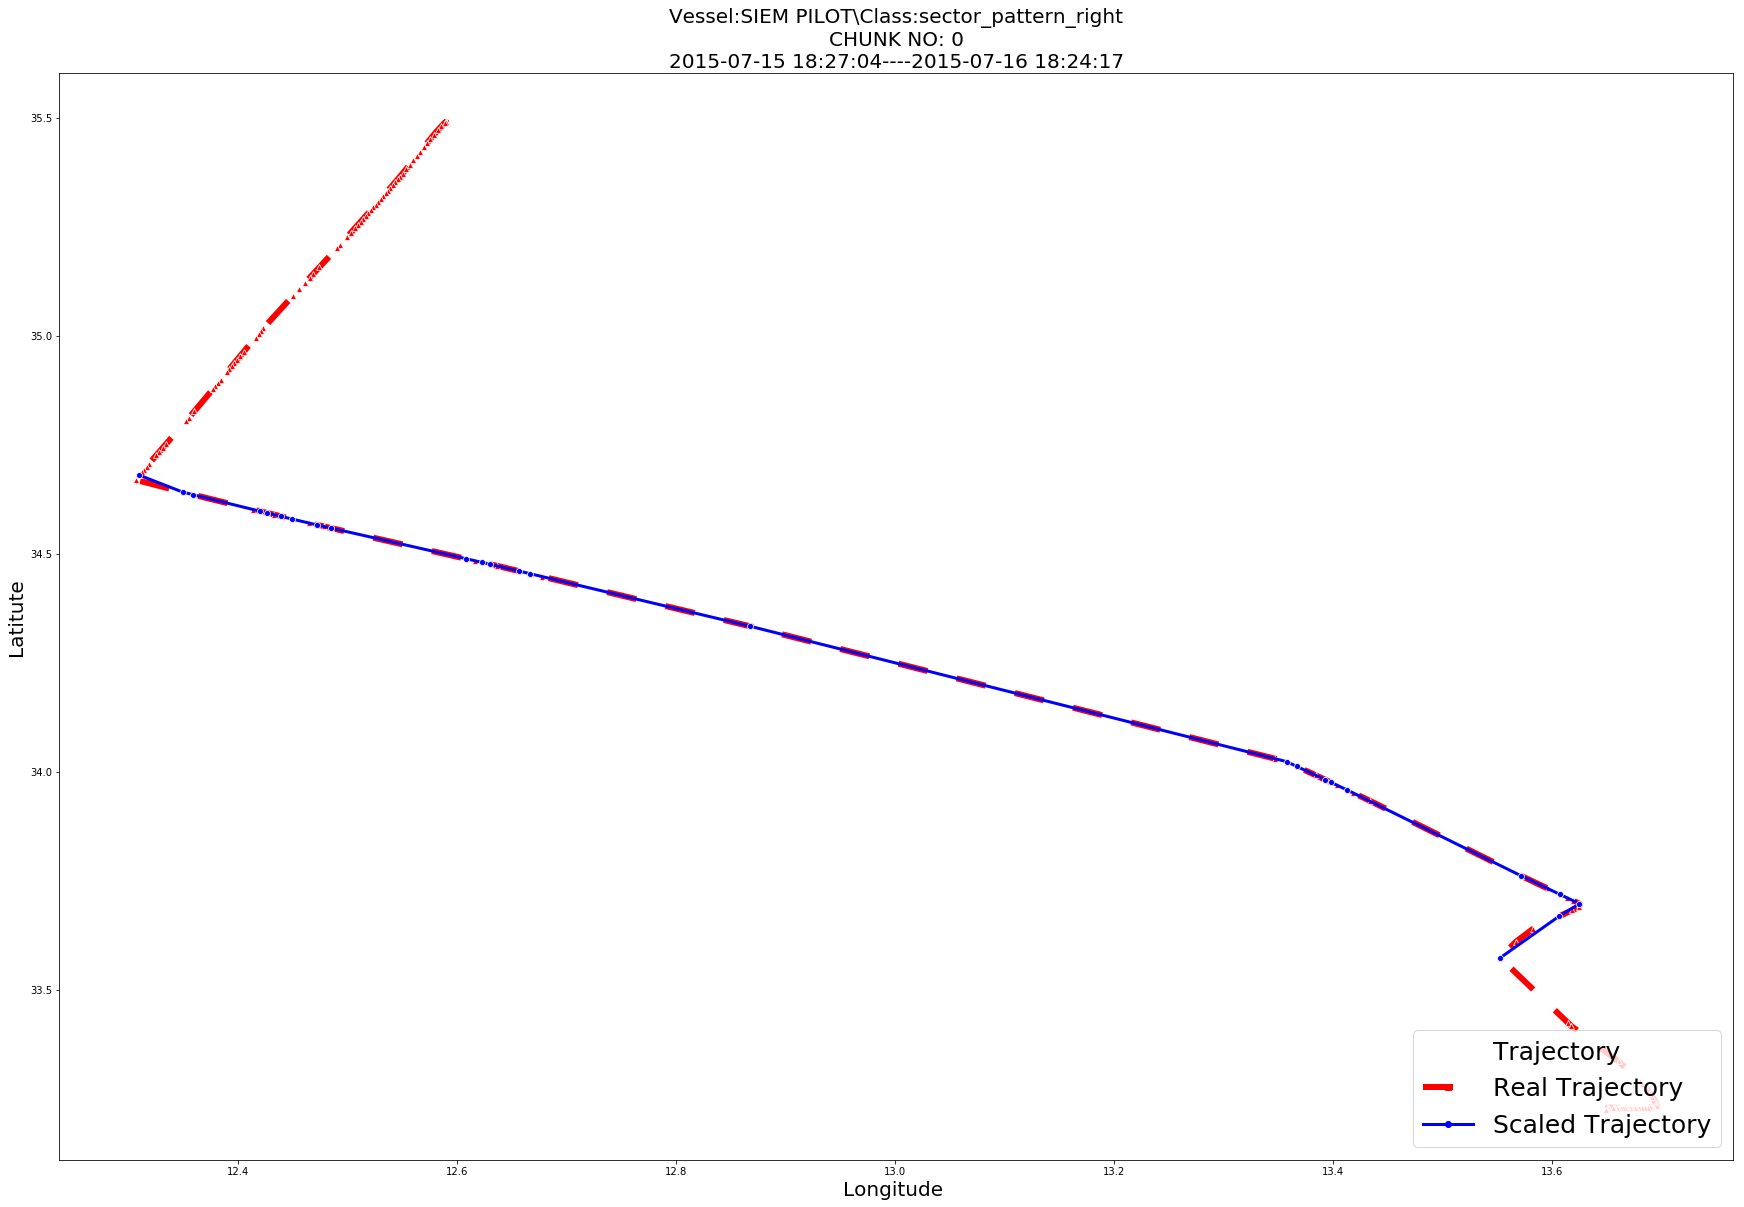

In [12]:
for x in ship_dfs:
    print("Chunk from {0} to {1}".format(x.index[0],x.index[-1]))
    n = 180  #chunk row size
    small_ship_dfs = [x[i:i+n] for i in range(0,real_data.shape[0],n)]
    small_ship_data_chunked ,small_ship_dfs = get_scaled_down_dfs(small_ship_dfs)
    small_ship ={"shipname":"SIEM PILOT","data":small_ship_data_chunked,"ship_dfs":small_ship_dfs}
    print("ERROR DIFFERENT SIZE OF DATA") if len(small_ship_dfs)!=small_ship["data"].shape[0] else None

    small_predictions,small_proba = experiments(small_ship,movement_list)
    print_results(movement_list,small_predictions,small_proba)
    small_proba_info,small_pattern_indexes = results(movement_list,small_proba,small_predictions)
    small_best_patterns = find_best_patterns(small_proba_info)
    plots(movement_list=movement_list,
          pattern_indexes=small_pattern_indexes,
          best_patterns=small_best_patterns,
          ship_name=small_ship["shipname"],
          ship_dfs=small_ship["ship_dfs"])